<a href="https://colab.research.google.com/github/wingyiuc/COMP3359_AI_Ap_Project/blob/master/Toy_Model_(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Getting started

In [0]:
""" Prepare Notebook for Google Colab """
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify directory of course materials in Google Drive
module_dir = '/content/drive/My Drive/COMP3359 AI Applications Group Project'

# Add course material directory in Google Drive to system path, for importing .py files later
# (Ref.: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab)
import sys
sys.path.append(module_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !pip install fastparquet
!pip install ta
!pip install PyWavelets

In [0]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import glob
import requests
import matplotlib
import math
import ta
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pywt

In [0]:
# raw_data_dir = os.path.join(module_dir, "Downloaded data/Daily data/Raw data/")
# processed_data_dir = os.path.join(module_dir, "Downloaded data/Daily data/Processed data/")

raw_data_dir = os.path.join(module_dir, "Cryptocurrency data/Raw data/")
processed_data_dir = os.path.join(module_dir, "Cryptocurrency data/Processed data/")
os.listdir(processed_data_dir)

['BTC_processed_conservative.csv',
 'DASH_processed_conservative.csv',
 'ETH_processed_conservative.csv',
 'DOGE_processed_conservative.csv',
 'LTC_processed_conservative.csv',
 'USDT_processed_conservative.csv',
 'NVC_processed_conservative.csv',
 'NMC_processed_conservative.csv',
 'FTC_processed_conservative.csv',
 'TRC_processed_conservative.csv',
 'PPC_processed_conservative.csv',
 'IXC_processed_conservative.csv',
 'FRC_processed_conservative.csv',
 'BTB_processed_conservative.csv',
 'WDC_processed_conservative.csv',
 'BTC_processed.csv',
 'ETH_processed.csv',
 'DOGE_processed.csv',
 'USDT_processed.csv',
 'NMC_processed.csv',
 'DASH_processed.csv',
 'PPC_processed.csv',
 'LTC_processed.csv',
 'NVC_processed.csv',
 'FTC_processed.csv',
 'TRC_processed.csv',
 'IXC_processed.csv',
 'FRC_processed.csv',
 'WDC_processed.csv',
 'BTB_processed.csv']

In [0]:
tickers = ['BTC', 'ETH', 'DOGE', 'USDT', 'DASH', "LTC", "NMC", "PPC", "NVC", "TRC", "FRC", "FTC", "IXC", "WDC", "BTB"]
# tickers = ["SPX"]
len(tickers)

15

## Exploring data

In [0]:
buy_sum = 0 
sell_sum = 0
hold_sum = 0
for ticker in tickers:
  price_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
  df = pd.read_csv(price_dir)
  buy_sum = buy_sum + df['buy_signal'].sum() 
  sell_sum = sell_sum + df['sell_signal'].sum()
  hold_sum = hold_sum + df['hold_signal'].sum()
print('sum of buy signals: ', buy_sum)
print('sum of sell signals:', sell_sum)
print('sum of hold signals:',hold_sum)

sum of buy signals:  7589
sum of sell signals: 8778
sum of hold signals: 8506


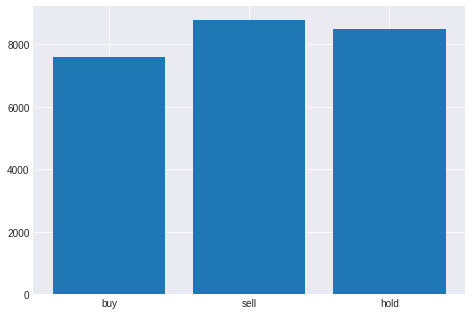

In [0]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['buy','sell','hold']
values = [buy_sum, sell_sum,hold_sum]
ax.bar(labels,values)
plt.show()

In [0]:
print('sum of obs after data processing', buy_sum + sell_sum + hold_sum)

sum of obs after data processing 24873


In [0]:
ticker = 'BTC'
data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
df = pd.read_csv(data_dir)
df.head()

,time,close,high,low,open,volumefrom,volumeto,ret_holding,15SMA,SMA_ret_holding1,buy_signal,sell_signal,hold_signal,close_ret,12EMA,50EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI
0,2013-04-11,124.90,188.7,110.20,165.0,118747.72,18867223.23,-0.063251,133.710000,0.015367,1,0,0,-0.243030,145.284333,87.712684,60.798513,19.204489,28.229613,2.618666,52.534220,12.516431,30.091575,213.472003,60.737997,30.593601,1.095791e+08,62.609170
1,2013-04-12,117.00,140.0,54.25,124.9,556468.03,47619189.45,-0.205128,135.764667,0.001228,0,0,1,-0.063251,140.932898,88.861206,61.911414,27.806557,22.955601,-1.440933,50.594625,-29.038179,-2.600867,211.884738,66.110976,34.533343,1.316533e+08,52.254324
2,2013-04-13,93.00,130.0,85.50,117.0,238347.58,26277415.26,-0.032258,135.931333,-0.001074,0,0,1,-0.205128,133.558606,89.023512,62.527030,25.146848,20.759888,-5.680621,45.141858,-6.093979,-7.538576,211.795017,66.316412,35.245247,1.142335e+08,47.746081
3,2013-04-14,90.00,110.0,84.44,93.0,166274.96,16197017.56,-0.084556,135.785333,-0.005224,0,1,0,-0.032258,126.857282,89.061805,63.071049,23.959408,19.586011,-8.457816,44.496306,-17.387097,-17.506418,212.140937,65.537634,34.553444,1.050830e+08,45.445031
4,2013-04-15,82.39,102.0,71.51,90.0,236673.01,20607774.11,-0.170288,135.076000,-0.017590,0,1,0,-0.084556,120.016161,88.800166,63.453602,25.223837,18.243578,-10.447686,42.823364,-23.820312,-15.767130,214.284307,60.307122,34.263198,9.918256e+07,41.923978


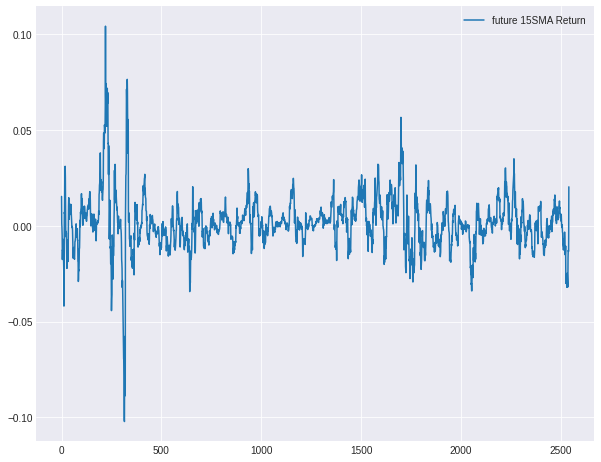

In [0]:
plt.figure(figsize=(10, 8))
# plt.plot(df.index, df['close'], label = 'Close')
plt.plot(df.index, df['SMA_ret_holding1'], label = 'future 15SMA Return')
# plt.plot(df.index, df['MACD'], label = 'MACD')
plt.legend()
plt.style.use('seaborn-darkgrid')

In [0]:
df['close_lag1'] = df['close'].shift(1)
df.dropna(inplace=True)
df['log_close'] = df['close'].apply(lambda x: math.log(x))
df['log_close_lag1'] = df['close_lag1'].apply(lambda x: math.log(x))
df['log_diff'] = df['log_close'] - df['log_close_lag1']
df.head()

,time,close,high,low,open,volumefrom,volumeto,ret_holding,15SMA,SMA_ret_holding1,buy_signal,sell_signal,hold_signal,close_ret,12EMA,50EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI,close_lag1,log_close,log_close_lag1,log_diff
1,2013-04-12,117.00,140.0,54.25,124.90,556468.03,47619189.45,-0.205128,135.764667,0.001228,0,0,1,-0.063251,140.932898,88.861206,61.911414,27.806557,22.955601,-1.440933,50.594625,-29.038179,-2.600867,211.884738,66.110976,34.533343,1.316533e+08,52.254324,124.90,4.762174,4.827513,-0.065339
2,2013-04-13,93.00,130.0,85.50,117.00,238347.58,26277415.26,-0.032258,135.931333,-0.001074,0,0,1,-0.205128,133.558606,89.023512,62.527030,25.146848,20.759888,-5.680621,45.141858,-6.093979,-7.538576,211.795017,66.316412,35.245247,1.142335e+08,47.746081,117.00,4.532599,4.762174,-0.229574
3,2013-04-14,90.00,110.0,84.44,93.00,166274.96,16197017.56,-0.084556,135.785333,-0.005224,0,1,0,-0.032258,126.857282,89.061805,63.071049,23.959408,19.586011,-8.457816,44.496306,-17.387097,-17.506418,212.140937,65.537634,34.553444,1.050830e+08,45.445031,93.00,4.499810,4.532599,-0.032790
4,2013-04-15,82.39,102.0,71.51,90.00,236673.01,20607774.11,-0.170288,135.076000,-0.017590,0,1,0,-0.084556,120.016161,88.800166,63.453602,25.223837,18.243578,-10.447686,42.823364,-23.820312,-15.767130,214.284307,60.307122,34.263198,9.918256e+07,41.923978,90.00,4.411464,4.499810,-0.088346
5,2013-04-16,68.36,84.5,50.01,82.39,572349.32,37401572.39,0.361469,132.700000,-0.012514,0,1,0,-0.170288,112.069060,87.998591,63.550759,28.118087,16.820860,-12.225661,39.848760,-23.704467,-21.637292,218.179793,49.323064,34.279398,1.015791e+08,37.681874,82.39,4.224788,4.411464,-0.186676


<Figure size 1080x720 with 0 Axes>

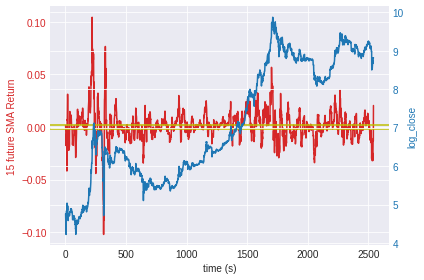

In [0]:
plt.figure(figsize=(15, 10))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('15 future SMA Return', color=color)
ax1.plot(df.index, df['SMA_ret_holding1'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=0.002,color='y')
ax1.axhline(y=-0.002,color='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('log_close', color=color)  # we already handled the x-label with ax1
ax2.plot(df.index,df['log_close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)



fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Toy Example of LSTM Prediction on Bitcoin Data

### Simple Normalization

In [0]:
ticker = 'BTC'
data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
df = pd.read_csv(data_dir)
df.head()

,time,close,high,low,open,volumefrom,volumeto,ret_holding,15SMA,SMA_ret_holding1,buy_signal,sell_signal,hold_signal,close_ret,12EMA,50EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI
0,2013-04-11,124.90,188.7,110.20,165.0,118747.72,18867223.23,-0.063251,133.710000,0.015367,1,0,0,-0.243030,145.284333,87.712684,60.798513,19.204489,28.229613,2.618666,52.534220,12.516431,30.091575,213.472003,60.737997,30.593601,1.095791e+08,62.609170
1,2013-04-12,117.00,140.0,54.25,124.9,556468.03,47619189.45,-0.205128,135.764667,0.001228,0,0,1,-0.063251,140.932898,88.861206,61.911414,27.806557,22.955601,-1.440933,50.594625,-29.038179,-2.600867,211.884738,66.110976,34.533343,1.316533e+08,52.254324
2,2013-04-13,93.00,130.0,85.50,117.0,238347.58,26277415.26,-0.032258,135.931333,-0.001074,0,0,1,-0.205128,133.558606,89.023512,62.527030,25.146848,20.759888,-5.680621,45.141858,-6.093979,-7.538576,211.795017,66.316412,35.245247,1.142335e+08,47.746081
3,2013-04-14,90.00,110.0,84.44,93.0,166274.96,16197017.56,-0.084556,135.785333,-0.005224,0,1,0,-0.032258,126.857282,89.061805,63.071049,23.959408,19.586011,-8.457816,44.496306,-17.387097,-17.506418,212.140937,65.537634,34.553444,1.050830e+08,45.445031
4,2013-04-15,82.39,102.0,71.51,90.0,236673.01,20607774.11,-0.170288,135.076000,-0.017590,0,1,0,-0.084556,120.016161,88.800166,63.453602,25.223837,18.243578,-10.447686,42.823364,-23.820312,-15.767130,214.284307,60.307122,34.263198,9.918256e+07,41.923978


In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = int(df.shape[0]*0.75)
# TRAIN_SPLIT = 1500
TRAIN_SPLIT

1906

In [0]:
df.columns

Index(['time', 'close', 'high', 'low', 'open', 'volumefrom', 'volumeto',
       'ret_holding', '15SMA', 'SMA_ret_holding1', 'buy_signal', 'sell_signal',
       'hold_signal', 'close_ret', '12EMA', '50EMA', '100EMA', 'minusDI',
       'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal', 'BB_hband',
       'BB_lband', 'ATR', 'ADI', 'MFI'],
      dtype='object')

In [0]:
df.shape

(2542, 28)

In [0]:
df['12_100EMA'] = df['12EMA'] / df['100EMA'] 
df['50_100EMA'] = df['50EMA'] / df['100EMA'] 

features_considered  = ['close', 'high', 'low', 'open', 'volumeto',
       '12_100EMA','50_100EMA', '100EMA', 'minusDI',
       'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
       'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']
# features_considered  = ['12_100EMA','50_100EMA', 'MACD']
y_labels = ['buy_signal', 'sell_signal', 'hold_signal']
signals = ['buy', 'sell', 'hold']

In [0]:
features = df[features_considered]
df['time'] = pd.to_datetime(df['time'])
features.index = df['time']
features.head()

,close,high,low,open,volumeto,12_100EMA,50_100EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI
time,,,,,,,,,,,,,,,,,,,
2013-04-11,124.90,188.7,110.20,165.0,18867223.23,2.389603,1.442678,60.798513,19.204489,28.229613,2.618666,52.534220,12.516431,30.091575,213.472003,60.737997,30.593601,1.095791e+08,62.609170
2013-04-12,117.00,140.0,54.25,124.9,47619189.45,2.276364,1.435296,61.911414,27.806557,22.955601,-1.440933,50.594625,-29.038179,-2.600867,211.884738,66.110976,34.533343,1.316533e+08,52.254324
2013-04-13,93.00,130.0,85.50,117.0,26277415.26,2.136014,1.423760,62.527030,25.146848,20.759888,-5.680621,45.141858,-6.093979,-7.538576,211.795017,66.316412,35.245247,1.142335e+08,47.746081
2013-04-14,90.00,110.0,84.44,93.0,16197017.56,2.011339,1.412087,63.071049,23.959408,19.586011,-8.457816,44.496306,-17.387097,-17.506418,212.140937,65.537634,34.553444,1.050830e+08,45.445031
2013-04-15,82.39,102.0,71.51,90.0,20607774.11,1.891400,1.399450,63.453602,25.223837,18.243578,-10.447686,42.823364,-23.820312,-15.767130,214.284307,60.307122,34.263198,9.918256e+07,41.923978


Now, scale all the moving averages by the maximum moving-average day, as described in the hypothesis. This function is kept general to help in evaluating different criteria for scaling without the need to modify a lot of code:

In [0]:
def preprocess_features(features):
  # standardize the dataset using the mean and standard deviation of the training data.
  x_dataset = features.values
  train_split = int(features.shape[0]*0.75)
  data_mean = x_dataset[:train_split].mean(axis=0)
  data_std = x_dataset[:train_split].std(axis=0)
  x_dataset = (x_dataset-data_mean)/data_std

  # standardize the x_dataset using minmax scaler
  # data_max = x_dataset[:train_split].max(axis=0)
  # data_min = x_dataset[:train_split].min(axis=0)
  # x_dataset = (x_dataset-data_min)/(data_max - data_min)
  return x_dataset

In [0]:
x_dataset = preprocess_features(features)
x_dataset[:2]

array([[-0.5442051 , -0.52361051, -0.55274671, -0.53129484, -0.37409337,
         4.94928789,  3.53931074, -0.56444962, -0.18539161,  0.49457433,
         0.04143985, -0.09305321, -0.07332226,  0.27412154, -0.51024815,
        -0.57483104, -0.36714474, -0.49494998,  0.52104963],
       [-0.54659749, -0.53776083, -0.57067596, -0.54344284, -0.31677797,
         4.51263127,  3.47229894, -0.56407109,  0.75802479, -0.01470902,
        -0.00735964, -0.22891998, -0.83220591, -0.38902028, -0.51065654,
        -0.5728323 , -0.35541011, -0.49329969, -0.07228978]])

In [0]:
def preprocess_outcome(outcome):
  return outcome.values

In [0]:
outcome = df[y_labels]
df['time'] = pd.to_datetime(df['time'])
outcome.index = df['time']

y_dataset = preprocess_outcome(outcome)
y_dataset

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [0]:
y_dataset.shape

(2542, 3)

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size):
  start_index = start_index + history_size
  labels = target[start_index: end_index]
  data = []
  
  
  if end_index is None:
    end_index = len(dataset) 

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

  return np.array(data), labels

In [0]:
past_history = 15

x_train, y_train  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                   start_index = 0, end_index = TRAIN_SPLIT, 
                                   history_size = past_history,
                                   )
x_val, y_val  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                   start_index = TRAIN_SPLIT-past_history, end_index = None, 
                                   history_size = past_history,
                                   )

In [0]:
print('x train shape:',x_train.shape,
      'y train shape:',y_train.shape,
      'x val shape:', x_val.shape,
      'y val shape:', y_val.shape)

x train shape: (1891, 15, 19) y train shape: (1891, 3) x val shape: (636, 15, 19) y val shape: (636, 3)


In [0]:
# Data Augmentation
y_train_df = pd.DataFrame(y_train,columns=['buy','sell','hold'])
print('buy signals',y_train_df['buy'].sum())
print('sell singlas',y_train_df['sell'].sum())
print('hold singals',y_train_df['hold'].sum())

from random import choices
# k = max(int((df['buy_signal'].sum() - df['hold_signal'].sum())/2),0)
# hold_indices = list(y_train_df.loc[y_train_df['hold']==1].index)
# hold_indices = choices(hold_indices,k=k)

k1 = max(int(- df['buy_signal'].sum() + 10000),0)
k2 = max(int(- df['sell_signal'].sum() + 10000),0)
k3 = max(int(- df['hold_signal'].sum() + 10000),0)
buy_indices = list(y_train_df.loc[y_train_df['buy']==1].index)
buy_indices = choices(buy_indices,k=k1)
sell_indices = list(y_train_df.loc[y_train_df['sell']==1].index)
sell_indices = choices(sell_indices,k=k2)
hold_indices = list(y_train_df.loc[y_train_df['hold']==1].index)
hold_indices = choices(hold_indices,k=k3)

buy signals 655
sell singlas 473
hold singals 763


In [0]:
# x_hold_resampled = x_train[hold_indices]
# y_hold_resampled = y_train[hold_indices]
# x_train = np.concatenate((x_train, x_hold_resampled))
# y_train = np.concatenate((y_train, y_hold_resampled))

x_buy_resampled = x_train[buy_indices]
y_buy_resampled = y_train[buy_indices]
x_train = np.concatenate((x_train, x_buy_resampled))
y_train = np.concatenate((y_train, y_buy_resampled))

x_sell_resampled = x_train[sell_indices]
y_sell_resampled = y_train[sell_indices]
x_train = np.concatenate((x_train, x_sell_resampled))
y_train = np.concatenate((y_train, y_sell_resampled))

x_hold_resampled = x_train[hold_indices]
y_hold_resampled = y_train[hold_indices]
x_train = np.concatenate((x_train, x_hold_resampled))
y_train = np.concatenate((y_train, y_hold_resampled))

In [0]:
# from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

In [0]:
y_train_df = pd.DataFrame(y_train,columns=['buy','sell','hold'])
print('buy signals',y_train_df['buy'].sum())
print('sell singlas',y_train_df['sell'].sum())
print('hold singals',y_train_df['hold'].sum())

buy signals 9829
sell singlas 9832
hold singals 9688


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
train_data_single

<RepeatDataset shapes: ((None, 15, 19), (None, 3)), types: (tf.float64, tf.int64)>

In [0]:
val_data_single

<RepeatDataset shapes: ((None, 15, 19), (None, 3)), types: (tf.float64, tf.int64)>

In [0]:
# self-defined loss function

from keras.utils import np_utils
import keras.backend as K
from itertools import product
import functools

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.expand_dims(y_pred_max, 1)
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):

        final_mask += (K.cast(weights[c_t, c_p],K.floatx()) * K.cast(y_pred_max_mat[:, c_p] ,K.floatx())* K.cast(y_true[:, c_t],K.floatx()))
    return K.categorical_crossentropy(y_pred, y_true) * final_mask
w_array = np.ones((3,3))
w_array[0,1] = 1.2   # buy becomes sell
w_array[1,0] = 1.2   # sell becomes buy
ncce = functools.partial(w_categorical_crossentropy, weights=w_array)
ncce.__name__ ='w_categorical_crossentropy'

In [0]:
""" Construct Classifier Model """
# Construct a neural network 
model = tf.keras.Sequential([
  tf.keras.layers.LSTM(58, input_shape=x_train.shape[-2:], return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(29, return_sequences=False),
  tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss=ncce, optimizer='adam', metrics=['accuracy'])
# Show model structure
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 15, 58)            18096     
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 58)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 29)                10208     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 90        
Total params: 28,394
Trainable params: 28,394
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
x_train.shape[-2:]

(15, 19)

In [0]:
# a sample prediction
for x, y in val_data_single.take(1):
  print(model.predict(x).shape)

(256, 3)


In [0]:
for x,y in val_data_single.take(1):
  print(y.shape)

(256, 3)


In [0]:
EPOCHS = 100
EVALUATION_INTERVAL = 200
history = model.fit(train_data_single, epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=val_data_single,
                    shuffle=False,
                    batch_size = 1,
                    # verbose=2,
                    validation_steps=50)
# model.reset_states()

Epoch 1/100
200/200 [==============================] - 2s 12ms/step - loss: 4.5709 - accuracy: 0.7538 - val_loss: 9.6545 - val_accuracy: 0.4129
Epoch 2/100
200/200 [==============================] - 1s 7ms/step - loss: 2.5633 - accuracy: 0.8507 - val_loss: 9.9611 - val_accuracy: 0.4004
Epoch 3/100
200/200 [==============================] - 1s 7ms/step - loss: 2.1776 - accuracy: 0.8720 - val_loss: 9.8020 - val_accuracy: 0.4083
Epoch 4/100
200/200 [==============================] - 1s 7ms/step - loss: 1.9154 - accuracy: 0.8867 - val_loss: 9.5476 - val_accuracy: 0.4241
Epoch 5/100
200/200 [==============================] - 1s 7ms/step - loss: 1.7490 - accuracy: 0.8965 - val_loss: 9.6626 - val_accuracy: 0.4193
Epoch 6/100
200/200 [==============================] - 1s 7ms/step - loss: 1.7111 - accuracy: 0.8980 - val_loss: 9.2386 - val_accuracy: 0.4395
Epoch 7/100
200/200 [==============================] - 1s 7ms/step - loss: 1.6393 - accuracy: 0.9018 - val_loss: 9.1341 - val_accuracy: 0.444

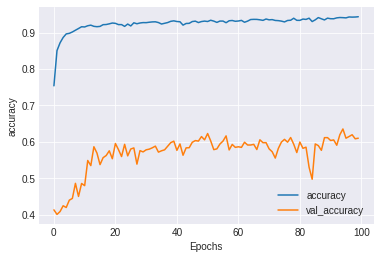

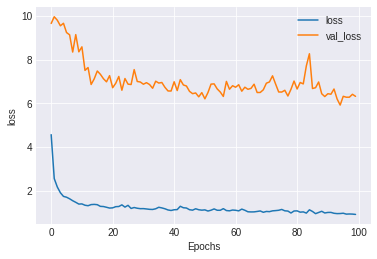

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [0]:
predictions = probability_model.predict(x_val)

In [0]:
predict_valid = np.argmax(predictions, axis = 1).astype(int)
# predict_valid = np.zeros(predictions.shape)
# predict_valid[x == 0,0] = 1
# predict_valid[x == 1,1] = 1
# predict_valid[x == 2,2] = 1
# predict_valid = predict_valid.astype(int)
# predict_valid.shape
predict_valid =  list(predict_valid)

In [0]:
def decode(datum):
    return np.argmax(datum)
def transform_y(y_val):
  y_true = []
  for i in range(y_val.shape[0]):
      y_true.append(decode(y_val[i]))
  y_true = np.array(y_true).astype(int)
  y_true = y_true.tolist()
  return y_true

In [0]:
y_true = transform_y(y_val)
y_true[:5]

[2, 2, 2, 2, 2]

In [0]:
# pred_table = pd.merge(predict_valid,y_true)
pred_table = pd.DataFrame({'Pred':predict_valid, 'y_truth':y_true},columns=['Pred','y_truth'])
pred_table.dropna(inplace=True)
pred_table.head()

,Pred,y_truth
0,1,2
1,2,2
2,2,2
3,2,2
4,2,2


In [0]:
# Accuracy matrix
label_dict = {0:"Buy", 1:"Sell", 2:"Hold"}
y_true_label = [label_dict[x] for x in y_true]
predict_valid_label = [label_dict[x] for x in predict_valid]
acc_mtx_labels = np.unique(y_true_label)
accuracy_matrix = confusion_matrix(y_true_label, predict_valid_label, labels = acc_mtx_labels)
pd.DataFrame(accuracy_matrix, index=acc_mtx_labels, columns=acc_mtx_labels)

,Buy,Hold,Sell
Buy,118,44,7
Hold,73,132,105
Sell,7,12,138


In [0]:
# Accuracy for all signals
accuracy_matrix_percentage = accuracy_matrix / accuracy_matrix.astype(np.float).sum()
print('Total accuracy:', np.trace(accuracy_matrix_percentage)*100)

Total accuracy: 61.00628930817611


Text(0.5, 18.5, 'Model Prediction')

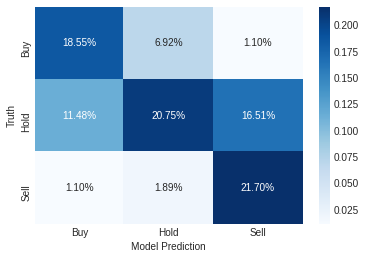

In [0]:
# Confusion Matrix Heatmap
acc_df = pd.DataFrame(accuracy_matrix_percentage, index=acc_mtx_labels, columns=acc_mtx_labels)
ax = sns.heatmap(acc_df,  
            fmt='.2%', cmap='Blues',annot=True)
# X - Y axis labels
ax.set_ylabel('Truth')
ax.set_xlabel('Model Prediction')

In [0]:
df_eval = df[['time','close','12EMA','50EMA','100EMA']].copy()
# df_eval['time'] = pd.to_datetime(df_eval['time'])
# df_eval = df_eval[df_eval['time'] > "2015-01-01"]
# df_eval.set_index('time',inplace=True)
# df_eval = df_eval.loc['1/1/2017':]
df_eval = df_eval.loc[TRAIN_SPLIT:]
df_eval = df_eval.reset_index(drop=True)
df_eval.head()

,time,close,12EMA,50EMA,100EMA
0,2018-06-30,6385.38,6300.517040,7114.188175,7795.050665
1,2018-07-01,6339.04,6306.443649,7083.790207,7766.218771
2,2018-07-02,6615.66,6354.015395,7065.432160,7743.435429
3,2018-07-03,6509.58,6377.948411,7043.634036,7719.002648
4,2018-07-04,6590.06,6410.580963,7025.846819,7696.647348


In [0]:
df_eval = pd.merge(df_eval, pred_table, left_index=True, right_index=True)
# df_eval.dropna(inplace=True)
df_eval.head()

,time,close,12EMA,50EMA,100EMA,Pred,y_truth
0,2018-06-30,6385.38,6300.517040,7114.188175,7795.050665,1,2
1,2018-07-01,6339.04,6306.443649,7083.790207,7766.218771,2,2
2,2018-07-02,6615.66,6354.015395,7065.432160,7743.435429,2,2
3,2018-07-03,6509.58,6377.948411,7043.634036,7719.002648,2,2
4,2018-07-04,6590.06,6410.580963,7025.846819,7696.647348,2,2


In [0]:
df_eval['position'] = np.where(df_eval['Pred']==0,1,np.where(df_eval['Pred'] == 1,-1,np.nan))
df_eval['position'] = df_eval['position'].fillna(method='ffill')
df_eval['position'] = df_eval['position'].fillna(0)
df_eval['daily_ret'] = (df_eval['close'] - df_eval['close'].shift(1)).shift(-1)
df_eval['daily_ret'] = df_eval['daily_ret'].fillna(0)
df_eval['port_ret'] = df_eval['position'] * df_eval['daily_ret']
df_eval['port_ret'] = df_eval['port_ret'].fillna(0)
df_eval['cum_ret'] = np.cumsum(df_eval['port_ret'])
df_eval['buy_and_hold'] = np.cumsum(df_eval['daily_ret'])

# Benchmark model
df_eval['bm_signal'] = np.where((df_eval['12EMA'] > df_eval['50EMA']) & (df_eval['50EMA'] > df_eval['100EMA']), 0, np.where((df_eval['12EMA'] < df_eval['50EMA']) & (df_eval['50EMA'] < df_eval['100EMA']), 1,2))
df_eval['bm_position'] = np.where(df_eval['bm_signal']==0,1,np.where(df_eval['bm_signal'] == 1,-1,np.nan))
df_eval['bm_position'] = df_eval['bm_position'].fillna(method='ffill')
df_eval['bm_position'] = df_eval['bm_position'].fillna(0)
df_eval['bm_port_ret'] = df_eval['bm_position'] * df_eval['daily_ret']
df_eval['bm_cum_ret'] = np.cumsum(df_eval['bm_port_ret'])

# Ideal model
df_eval['ideal_position'] = np.where(df_eval['y_truth']==0,1,np.where(df_eval['y_truth'] == 1,-1,np.nan))
df_eval['ideal_position'] = df_eval['ideal_position'].fillna(method='ffill')
df_eval['ideal_position'] = df_eval['ideal_position'].fillna(0)
df_eval['ideal_port_ret'] = df_eval['ideal_position'] * df_eval['daily_ret']
df_eval['ideal_cum_ret'] = np.cumsum(df_eval['ideal_port_ret'])

df_eval.set_index('time',inplace=True)
df_eval.tail()

,close,12EMA,50EMA,100EMA,Pred,y_truth,position,daily_ret,port_ret,cum_ret,buy_and_hold,bm_signal,bm_position,bm_port_ret,bm_cum_ret,ideal_position,ideal_port_ret,ideal_cum_ret
time,,,,,,,,,,,,,,,,,,
2020-03-22,5828.15,6184.406766,7748.461133,8149.698925,1,1,-1.0,675.38,-675.38,8808.17,118.15,1,-1.0,-675.38,-2823.59,-1.0,-675.38,16151.71
2020-03-23,6503.53,6233.502648,7699.640304,8117.101520,1,1,-1.0,263.65,-263.65,8544.52,381.80,1,-1.0,-263.65,-3087.24,-1.0,-263.65,15888.06
2020-03-24,6767.18,6315.606856,7663.073233,8090.370401,2,1,-1.0,-72.97,72.97,8617.49,308.83,1,-1.0,72.97,-3014.27,-1.0,72.97,15961.03
2020-03-25,6694.21,6373.853494,7625.078597,8062.723661,0,1,1.0,63.74,63.74,8681.23,372.57,1,-1.0,-63.74,-3078.01,-1.0,-63.74,15897.29
2020-03-26,6757.95,6432.945264,7591.073554,8036.886558,0,0,1.0,0.00,0.00,8681.23,372.57,1,-1.0,-0.00,-3078.01,1.0,0.00,15897.29


In [0]:
df_eval = df[['time','close','12EMA','50EMA','100EMA']].copy()
# df_eval['time'] = pd.to_datetime(df_eval['time'])
# df_eval = df_eval[df_eval['time'] > "2015-01-01"]
# df_eval.set_index('time',inplace=True)
# df_eval = df_eval.loc['1/1/2017':]
df_eval = df_eval.loc[TRAIN_SPLIT:]
df_eval = df_eval.reset_index(drop=True)
df_eval.head()

,time,close,12EMA,50EMA,100EMA
0,2018-06-30,6385.38,6300.517040,7114.188175,7795.050665
1,2018-07-01,6339.04,6306.443649,7083.790207,7766.218771
2,2018-07-02,6615.66,6354.015395,7065.432160,7743.435429
3,2018-07-03,6509.58,6377.948411,7043.634036,7719.002648
4,2018-07-04,6590.06,6410.580963,7025.846819,7696.647348


In [0]:
df_eval = pd.merge(df_eval, pred_table, left_index=True, right_index=True)
# df_eval.dropna(inplace=True)
df_eval.head()

,time,close,12EMA,50EMA,100EMA,Pred,y_truth
0,2018-06-30,6385.38,6300.517040,7114.188175,7795.050665,1,2
1,2018-07-01,6339.04,6306.443649,7083.790207,7766.218771,2,2
2,2018-07-02,6615.66,6354.015395,7065.432160,7743.435429,2,2
3,2018-07-03,6509.58,6377.948411,7043.634036,7719.002648,2,2
4,2018-07-04,6590.06,6410.580963,7025.846819,7696.647348,2,2


In [0]:
df_eval['position'] = np.where(df_eval['Pred']==0,1,np.where(df_eval['Pred'] == 1,-1,np.nan))
df_eval['position'] = df_eval['position'].fillna(method='ffill')
df_eval['position'] = df_eval['position'].fillna(0)
df_eval['daily_ret'] = (df_eval['close'] - df_eval['close'].shift(1)).shift(-1)
df_eval['daily_ret'] = df_eval['daily_ret'].fillna(0)
df_eval['port_ret'] = df_eval['position'] * df_eval['daily_ret']
df_eval['port_ret'] = df_eval['port_ret'].fillna(0)
df_eval['cum_ret'] = np.cumsum(df_eval['port_ret'])
df_eval['buy_and_hold'] = np.cumsum(df_eval['daily_ret'])

# Benchmark model
df_eval['bm_signal'] = np.where((df_eval['12EMA'] > df_eval['50EMA']) & (df_eval['50EMA'] > df_eval['100EMA']), 0, np.where((df_eval['12EMA'] < df_eval['50EMA']) & (df_eval['50EMA'] < df_eval['100EMA']), 1,2))
df_eval['bm_position'] = np.where(df_eval['bm_signal']==0,1,np.where(df_eval['bm_signal'] == 1,-1,np.nan))
df_eval['bm_position'] = df_eval['bm_position'].fillna(method='ffill')
df_eval['bm_position'] = df_eval['bm_position'].fillna(0)
df_eval['bm_port_ret'] = df_eval['bm_position'] * df_eval['daily_ret']
df_eval['bm_cum_ret'] = np.cumsum(df_eval['bm_port_ret'])

# Ideal model
df_eval['ideal_position'] = np.where(df_eval['y_truth']==0,1,np.where(df_eval['y_truth'] == 1,-1,np.nan))
df_eval['ideal_position'] = df_eval['ideal_position'].fillna(method='ffill')
df_eval['ideal_position'] = df_eval['ideal_position'].fillna(0)
df_eval['ideal_port_ret'] = df_eval['ideal_position'] * df_eval['daily_ret']
df_eval['ideal_cum_ret'] = np.cumsum(df_eval['ideal_port_ret'])

df_eval.set_index('time',inplace=True)
df_eval.tail()

,close,12EMA,50EMA,100EMA,Pred,y_truth,position,daily_ret,port_ret,cum_ret,buy_and_hold,bm_signal,bm_position,bm_port_ret,bm_cum_ret,ideal_position,ideal_port_ret,ideal_cum_ret
time,,,,,,,,,,,,,,,,,,
2020-03-22,5828.15,6184.406766,7748.461133,8149.698925,1,1,-1.0,675.38,-675.38,8808.17,118.15,1,-1.0,-675.38,-2823.59,-1.0,-675.38,16151.71
2020-03-23,6503.53,6233.502648,7699.640304,8117.101520,1,1,-1.0,263.65,-263.65,8544.52,381.80,1,-1.0,-263.65,-3087.24,-1.0,-263.65,15888.06
2020-03-24,6767.18,6315.606856,7663.073233,8090.370401,2,1,-1.0,-72.97,72.97,8617.49,308.83,1,-1.0,72.97,-3014.27,-1.0,72.97,15961.03
2020-03-25,6694.21,6373.853494,7625.078597,8062.723661,0,1,1.0,63.74,63.74,8681.23,372.57,1,-1.0,-63.74,-3078.01,-1.0,-63.74,15897.29
2020-03-26,6757.95,6432.945264,7591.073554,8036.886558,0,0,1.0,0.00,0.00,8681.23,372.57,1,-1.0,-0.00,-3078.01,1.0,0.00,15897.29


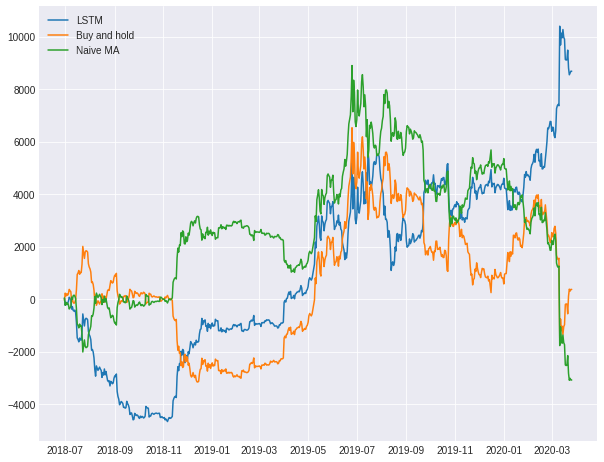

In [0]:
plt.figure(figsize=(10, 8))
plt.plot(df_eval.index, df_eval['cum_ret'], label = 'LSTM')
plt.plot(df_eval.index, df_eval['buy_and_hold'], label = "Buy and hold")
plt.plot(df_eval.index, df_eval['bm_cum_ret'], label = "Naive MA")
# plt.plot(df_eval.index, df_eval['ideal_cum_ret'], label = "Ideal")
plt.legend()
plt.style.use('seaborn-darkgrid')

## Benchmark Model

In [0]:
ticker = 'BTC'
data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
df_bm = pd.read_csv(data_dir)
# df_bm.head()
# ticker = 'SPX'
# data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
# df_bm = pd.read_csv(data_dir)
df_bm.head()

,time,close,high,low,open,volumefrom,volumeto,ret_holding,15SMA,SMA_ret_holding1,buy_signal,sell_signal,hold_signal,close_ret,12EMA,50EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI
0,2013-04-11,124.90,188.7,110.20,165.0,118747.72,18867223.23,-0.063251,133.710000,0.015367,1,0,0,-0.243030,145.284333,87.712684,60.798513,19.204489,28.229613,2.618666,52.534220,12.516431,30.091575,213.472003,60.737997,30.593601,1.095791e+08,62.609170
1,2013-04-12,117.00,140.0,54.25,124.9,556468.03,47619189.45,-0.205128,135.764667,0.001228,0,0,1,-0.063251,140.932898,88.861206,61.911414,27.806557,22.955601,-1.440933,50.594625,-29.038179,-2.600867,211.884738,66.110976,34.533343,1.316533e+08,52.254324
2,2013-04-13,93.00,130.0,85.50,117.0,238347.58,26277415.26,-0.032258,135.931333,-0.001074,0,0,1,-0.205128,133.558606,89.023512,62.527030,25.146848,20.759888,-5.680621,45.141858,-6.093979,-7.538576,211.795017,66.316412,35.245247,1.142335e+08,47.746081
3,2013-04-14,90.00,110.0,84.44,93.0,166274.96,16197017.56,-0.084556,135.785333,-0.005224,0,1,0,-0.032258,126.857282,89.061805,63.071049,23.959408,19.586011,-8.457816,44.496306,-17.387097,-17.506418,212.140937,65.537634,34.553444,1.050830e+08,45.445031
4,2013-04-15,82.39,102.0,71.51,90.0,236673.01,20607774.11,-0.170288,135.076000,-0.017590,0,1,0,-0.084556,120.016161,88.800166,63.453602,25.223837,18.243578,-10.447686,42.823364,-23.820312,-15.767130,214.284307,60.307122,34.263198,9.918256e+07,41.923978


In [0]:
df_bm['bm_signal'] = np.where((df_bm['12EMA'] > df_bm['50EMA']) & (df_bm['50EMA'] > df_bm['100EMA']), 0, np.where((df_bm['12EMA'] < df_bm['50EMA']) & (df_bm['50EMA'] < df_bm['100EMA']), 1,2))
df_bm.head()

,time,close,high,low,open,volumefrom,volumeto,ret_holding,15SMA,SMA_ret_holding1,buy_signal,sell_signal,hold_signal,close_ret,12EMA,50EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI,bm_signal
0,2013-04-11,124.90,188.7,110.20,165.0,118747.72,18867223.23,-0.063251,133.710000,0.015367,1,0,0,-0.243030,145.284333,87.712684,60.798513,19.204489,28.229613,2.618666,52.534220,12.516431,30.091575,213.472003,60.737997,30.593601,1.095791e+08,62.609170,0
1,2013-04-12,117.00,140.0,54.25,124.9,556468.03,47619189.45,-0.205128,135.764667,0.001228,0,0,1,-0.063251,140.932898,88.861206,61.911414,27.806557,22.955601,-1.440933,50.594625,-29.038179,-2.600867,211.884738,66.110976,34.533343,1.316533e+08,52.254324,0
2,2013-04-13,93.00,130.0,85.50,117.0,238347.58,26277415.26,-0.032258,135.931333,-0.001074,0,0,1,-0.205128,133.558606,89.023512,62.527030,25.146848,20.759888,-5.680621,45.141858,-6.093979,-7.538576,211.795017,66.316412,35.245247,1.142335e+08,47.746081,0
3,2013-04-14,90.00,110.0,84.44,93.0,166274.96,16197017.56,-0.084556,135.785333,-0.005224,0,1,0,-0.032258,126.857282,89.061805,63.071049,23.959408,19.586011,-8.457816,44.496306,-17.387097,-17.506418,212.140937,65.537634,34.553444,1.050830e+08,45.445031,0
4,2013-04-15,82.39,102.0,71.51,90.0,236673.01,20607774.11,-0.170288,135.076000,-0.017590,0,1,0,-0.084556,120.016161,88.800166,63.453602,25.223837,18.243578,-10.447686,42.823364,-23.820312,-15.767130,214.284307,60.307122,34.263198,9.918256e+07,41.923978,0


In [0]:
y_labels = ['buy_signal', 'sell_signal', 'hold_signal']
signals = ['buy', 'sell', 'hold']

y_val = df_bm[y_labels]
y_val = np.array(y_val)
y_true = transform_y(y_val)
y_true[:5]

[0, 2, 2, 1, 1]

In [0]:
bm_pred = list(np.array(df_bm['bm_signal']))
bm_pred[:5]

[0, 0, 0, 0, 0]

In [0]:
# Accuracy matrix
label_dict = {0:"Buy", 1:"Sell", 2:"Hold"}
y_true_label = [label_dict[x] for x in y_true]
predict_valid_label = [label_dict[x] for x in bm_pred]
acc_mtx_labels = np.unique(y_true_label)
accuracy_matrix = confusion_matrix(y_true_label, predict_valid_label, labels = acc_mtx_labels)
pd.DataFrame(accuracy_matrix, index=acc_mtx_labels, columns=acc_mtx_labels)

,Buy,Hold,Sell
Buy,569,140,117
Hold,506,185,384
Sell,165,158,318


In [0]:
# Accuracy for all signals
accuracy_matrix_percentage = accuracy_matrix / accuracy_matrix.astype(np.float).sum()
print('Total accuracy:', np.trace(accuracy_matrix_percentage)*100)

Total accuracy: 42.17151848937844


Text(0.5, 18.5, 'Model Prediction')

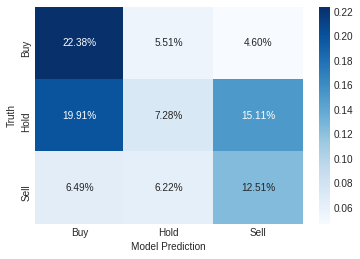

In [0]:
# Confusion Matrix Heatmap
acc_df = pd.DataFrame(accuracy_matrix_percentage, index=acc_mtx_labels, columns=acc_mtx_labels)
ax = sns.heatmap(acc_df,  
            fmt='.2%', cmap='Blues',annot=True)
# X - Y axis labels
ax.set_ylabel('Truth')
ax.set_xlabel('Model Prediction')

## Wavelet Transform & Stacked Autoencoder

In [0]:
ticker = 'BTC'
data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
df = pd.read_csv(data_dir)
df.head()
# ticker = 'SPX'
# data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
# df = pd.read_csv(data_dir)
# df.head()

,time,close,high,low,open,volumefrom,volumeto,ret_holding,15SMA,SMA_ret_holding1,buy_signal,sell_signal,hold_signal,close_ret,12EMA,50EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI
0,2013-04-11,124.90,188.7,110.20,165.0,118747.72,18867223.23,-0.063251,113.921333,-0.087900,0,1,0,-0.243030,145.284333,87.712684,60.798513,19.204489,28.229613,2.618666,52.534220,12.516431,30.091575,213.472003,60.737997,30.593601,1.095791e+08,62.609170
1,2013-04-12,117.00,140.0,54.25,124.9,556468.03,47619189.45,-0.205128,114.721333,-0.019476,0,0,1,-0.063251,140.932898,88.861206,61.911414,27.806557,22.955601,-1.440933,50.594625,-29.038179,-2.600867,211.884738,66.110976,34.533343,1.316533e+08,52.254324
2,2013-04-13,93.00,130.0,85.50,117.0,238347.58,26277415.26,-0.032258,115.454667,0.241448,1,0,0,-0.205128,133.558606,89.023512,62.527030,25.146848,20.759888,-5.680621,45.141858,-6.093979,-7.538576,211.795017,66.316412,35.245247,1.142335e+08,47.746081
3,2013-04-14,90.00,110.0,84.44,93.0,166274.96,16197017.56,-0.084556,118.217333,0.313526,1,0,0,-0.032258,126.857282,89.061805,63.071049,23.959408,19.586011,-8.457816,44.496306,-17.387097,-17.506418,212.140937,65.537634,34.553444,1.050830e+08,45.445031
4,2013-04-15,82.39,102.0,71.51,90.0,236673.01,20607774.11,-0.170288,121.817333,0.478545,1,0,0,-0.084556,120.016161,88.800166,63.453602,25.223837,18.243578,-10.447686,42.823364,-23.820312,-15.767130,214.284307,60.307122,34.263198,9.918256e+07,41.923978


In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = int(df.shape[0]*0.75)
# TRAIN_SPLIT = 1500
TRAIN_SPLIT

1896

In [0]:
df.columns

Index(['time', 'close', 'high', 'low', 'open', 'volumefrom', 'volumeto',
       'ret_holding', '15SMA', 'SMA_ret_holding1', 'buy_signal', 'sell_signal',
       'hold_signal', 'close_ret', '12EMA', '50EMA', '100EMA', 'minusDI',
       'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal', 'BB_hband',
       'BB_lband', 'ATR', 'ADI', 'MFI'],
      dtype='object')

In [0]:
df.shape

(2529, 28)

In [0]:
df['12_100EMA'] = df['12EMA'] / df['100EMA'] 
df['50_100EMA'] = df['50EMA'] / df['100EMA'] 
# df.dropna(inplace=True)

# features_considered  = ['close', 'high', 'low', 'open', 'volumefrom', 'volumeto',
#        '12EMA', '50EMA', '100EMA', 'minusDI',
#        'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
#        'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']
# features_considered  = ['12_100EMA','50_100EMA',
#                         'MACD','minusDI','plusDI']
features_considered  = ['close', 'high', 'low', 'open', 'volumeto',
       '12_100EMA','50_100EMA', '100EMA', 'minusDI',
       'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
       'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']

y_labels = ['buy_signal', 'sell_signal', 'hold_signal']
signals = ['buy', 'sell', 'hold']

In [0]:
features = df[features_considered]
df['time'] = pd.to_datetime(df['time'])
features.index = df['time']
features.head()

,close,high,low,open,volumeto,12_100EMA,50_100EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI
time,,,,,,,,,,,,,,,,,,,
2013-04-11,124.90,188.7,110.20,165.0,18867223.23,2.389603,1.442678,60.798513,19.204489,28.229613,2.618666,52.534220,12.516431,30.091575,213.472003,60.737997,30.593601,1.095791e+08,62.609170
2013-04-12,117.00,140.0,54.25,124.9,47619189.45,2.276364,1.435296,61.911414,27.806557,22.955601,-1.440933,50.594625,-29.038179,-2.600867,211.884738,66.110976,34.533343,1.316533e+08,52.254324
2013-04-13,93.00,130.0,85.50,117.0,26277415.26,2.136014,1.423760,62.527030,25.146848,20.759888,-5.680621,45.141858,-6.093979,-7.538576,211.795017,66.316412,35.245247,1.142335e+08,47.746081
2013-04-14,90.00,110.0,84.44,93.0,16197017.56,2.011339,1.412087,63.071049,23.959408,19.586011,-8.457816,44.496306,-17.387097,-17.506418,212.140937,65.537634,34.553444,1.050830e+08,45.445031
2013-04-15,82.39,102.0,71.51,90.0,20607774.11,1.891400,1.399450,63.453602,25.223837,18.243578,-10.447686,42.823364,-23.820312,-15.767130,214.284307,60.307122,34.263198,9.918256e+07,41.923978


In [0]:
features.shape

(2529, 19)

Now, scale all the moving averages by the maximum moving-average day, as described in the hypothesis. This function is kept general to help in evaluating different criteria for scaling without the need to modify a lot of code:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8505276630>,
      dtype=object)

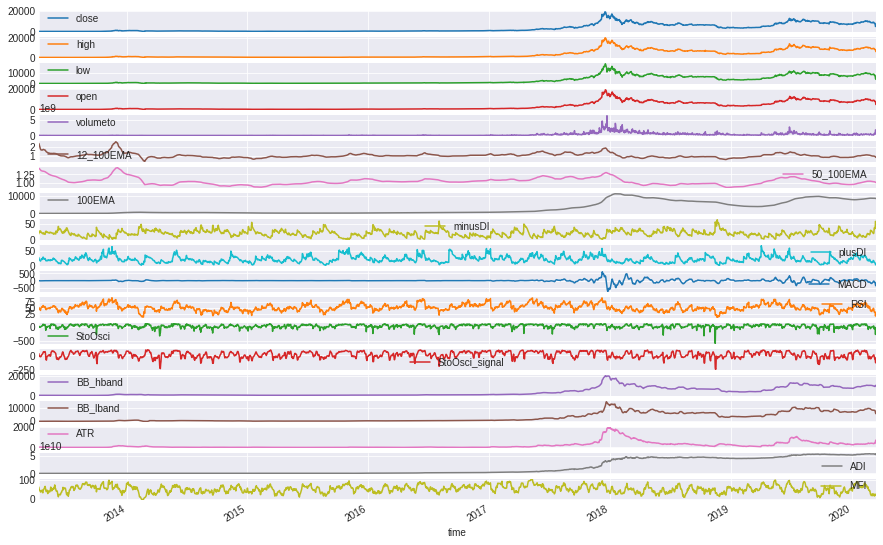

In [0]:
features.plot(subplots=True,figsize=(15, 10))

In [0]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
def preprocess_features(features):
  
  x_dataset = features.values
  train_split = TRAIN_SPLIT

  # standardize the dataset using the mean and standard deviation of the training data.
  data_mean = x_dataset[:train_split].mean(axis=0)
  data_std = x_dataset[:train_split].std(axis=0)
  x_dataset = (x_dataset-data_mean)/data_std

  # standardize the x_dataset using minmax scaler
  # data_max = x_dataset[:train_split].max(axis=0)
  # data_min = x_dataset[:train_split].min(axis=0)
  # x_dataset = (x_dataset-data_min)/(data_max - data_min)

  # Wavelet transform
  # coeffs, freqs = pywt.cwt(x_dataset,scales=np.arange(1,2),wavelet='morl')
  # x_dataset = coeffs.reshape(-1, coeffs.shape[-1])

  return x_dataset

In [0]:
x_dataset = preprocess_features(features)
x_dataset

array([[-0.53833821, -0.51774181, -0.54682422, ..., -0.36380494,
        -0.48932446,  0.51558128],
       [-0.54073519, -0.53191701, -0.56479493, ..., -0.35209348,
        -0.48764125, -0.0782826 ],
       [-0.54801717, -0.53482773, -0.55475767, ..., -0.34997724,
        -0.48896955, -0.33683615],
       ...,
       [ 1.8345128 ,  1.75555603,  1.86349329, ...,  0.76839604,
         3.80382465, -1.52897579],
       [ 0.91559382,  1.75129764,  0.93901491, ...,  1.37067207,
         3.68390083, -1.75886037],
       [ 1.13277884,  1.16926734,  0.68614337, ...,  1.67251413,
         3.7668615 , -1.90054396]])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fab1e430400>,
      dtype=object)

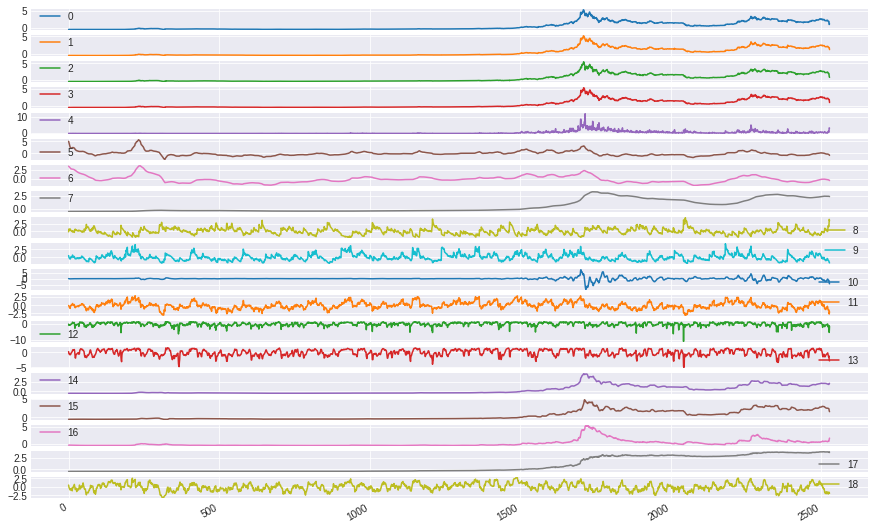

In [0]:
pd.DataFrame(x_dataset).plot(subplots=True,figsize=(15, 10))

In [0]:
x_dataset.shape

(2542, 19)

In [0]:
#Stacked Autoencoder 

input_size = x_dataset.shape[1]
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_dataset, x_dataset, epochs=5)

Epoch 1/5
2542/2542 [==============================] - 0s 119us/step - loss: -0.0552
Epoch 2/5
2542/2542 [==============================] - 0s 80us/step - loss: -47.2596
Epoch 3/5
2542/2542 [==============================] - 0s 86us/step - loss: -696.8160
Epoch 4/5
2542/2542 [==============================] - 0s 83us/step - loss: -3713.1283
Epoch 5/5
2542/2542 [==============================] - 0s 89us/step - loss: -12132.8541


In [0]:
x_dataset = autoencoder.predict(x_dataset)
x_dataset[:5]

array([[3.1318246e-32, 8.3920375e-02, 0.0000000e+00, 2.2166935e-15,
        2.7908051e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        7.7581090e-01, 0.0000000e+00, 0.0000000e+00, 2.4237731e-02,
        0.0000000e+00, 0.0000000e+00, 2.9159445e-31, 4.9681464e-01,
        2.9878324e-13, 3.6119109e-01, 0.0000000e+00],
       [9.4694547e-27, 8.3035462e-02, 2.3250017e-35, 5.4864685e-13,
        2.2762454e-01, 2.3060008e-36, 0.0000000e+00, 0.0000000e+00,
        6.4308411e-01, 9.2834841e-38, 0.0000000e+00, 3.7053350e-02,
        0.0000000e+00, 0.0000000e+00, 7.3505831e-26, 3.7885675e-01,
        4.9933294e-11, 2.8248775e-01, 0.0000000e+00],
       [9.6475008e-26, 8.2960039e-02, 5.0288259e-34, 1.5136496e-12,
        2.1914396e-01, 5.9477994e-35, 0.0000000e+00, 0.0000000e+00,
        6.1538219e-01, 2.7081717e-36, 0.0000000e+00, 4.0058643e-02,
        0.0000000e+00, 0.0000000e+00, 7.2376479e-25, 3.5856518e-01,
        1.2798965e-10, 2.6948270e-01, 0.0000000e+00],
       [2.4412755e-23,

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe11cf983c8>,
      dtype=object)

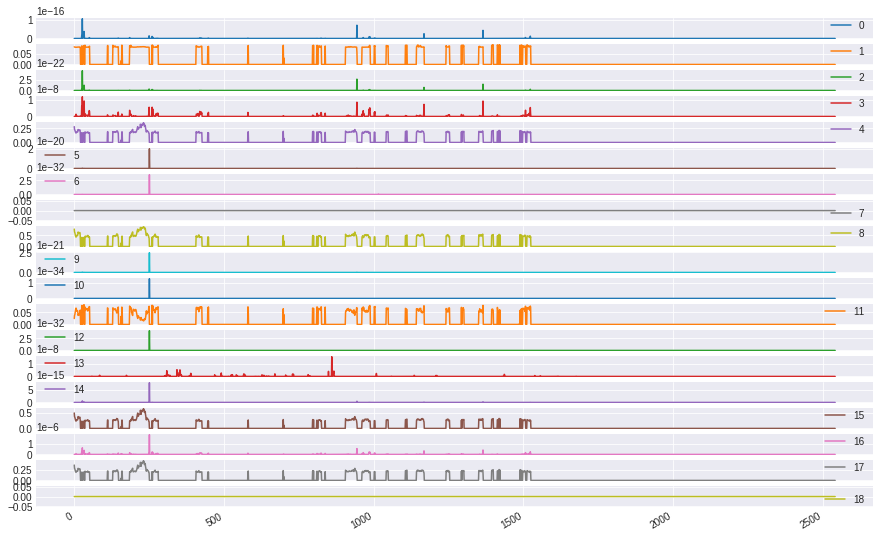

In [0]:
pd.DataFrame(x_dataset).plot(subplots=True,figsize=(15, 10))

In [0]:
df_x_dataset = pd.DataFrame(data=x_dataset,index=features.index,columns = features.columns)
df_x_dataset.head()

,close,high,low,open,volumeto,12_100EMA,50_100EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI
time,,,,,,,,,,,,,,,,,,,
2013-04-11,0.002363,0.063098,-0.006388,0.048604,0.654081,-0.212375,-1.160935,0.200416,0.603306,-0.086994,-0.110037,0.058745,0.059204,-0.099878,-0.049932,0.118195,0.001938,0.096041,-0.049497
2013-04-12,0.000877,0.062843,-0.003013,0.054763,0.594075,-0.176819,-1.085218,0.265972,0.415823,-0.145315,0.050977,-0.067153,0.079997,0.059625,-0.058680,0.037243,-0.006211,0.025462,0.024778
2013-04-13,0.001498,0.065360,-0.004328,0.045146,0.535938,-0.117048,-1.012211,0.178541,0.411141,-0.092177,0.006500,0.008218,0.056689,-0.024881,0.001058,0.029411,-0.009657,-0.005100,0.057000
2013-04-14,0.000933,0.066149,-0.003801,0.040145,0.481543,-0.068563,-0.942998,0.118325,0.398000,-0.065841,0.003017,-0.022118,0.059226,0.020052,0.001214,0.004216,-0.011186,-0.020066,0.073077
2013-04-15,0.000915,0.066218,-0.002496,0.038792,0.424484,-0.026681,-0.869755,0.093307,0.349039,-0.070206,0.023883,-0.032948,0.088403,0.016407,-0.018061,0.008295,-0.011669,-0.044124,0.097857


<Figure size 720x576 with 0 Axes>

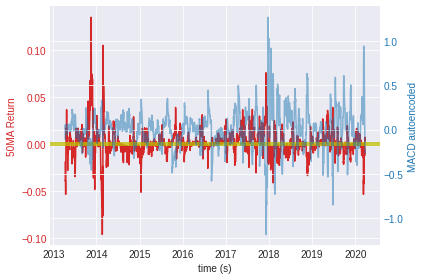

In [0]:
plt.figure(figsize=(10, 8))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('50MA Return', color=color)
ax1.plot(df_x_dataset.index, df['SMA_ret_holding1'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=0.001,color='y')
ax1.axhline(y=-0.001,color='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('MACD autoencoded', color=color)  # we already handled the x-label with ax1
ax2.plot(df_x_dataset.index,df_x_dataset['MACD'], color=color,alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)



fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [0]:
def preprocess_outcome(outcome):
  return outcome.values

In [0]:
outcome = df[y_labels]
df['time'] = pd.to_datetime(df['time'])
outcome.index = df['time']

y_dataset = preprocess_outcome(outcome)
y_dataset

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [0]:
y_dataset.shape

(2529, 3)

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size):
  start_index = start_index + history_size
  labels = target[start_index: end_index]
  data = []
  
  
  if end_index is None:
    end_index = len(dataset) 

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

  return np.array(data), labels

In [0]:
past_history = 15

x_train, y_train  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                   start_index = 0, end_index = TRAIN_SPLIT, 
                                   history_size = past_history,
                                   )
x_val, y_val  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                   start_index = TRAIN_SPLIT-past_history, end_index = None, 
                                   history_size = past_history,
                                   )

In [0]:
print('x train shape:',x_train.shape,
      'y train shape:',y_train.shape,
      'x val shape:', x_val.shape,
      'y val shape:', y_val.shape)

x train shape: (1881, 15, 19) y train shape: (1881, 3) x val shape: (633, 15, 19) y val shape: (633, 3)


In [0]:
y_train_df = pd.DataFrame(y_train,columns=['buy','sell','hold'])

from random import choices
k = int((df['buy_signal'].sum() + df['sell_signal'].sum() - df['hold_signal'].sum())/3)
hold_indices = list(y_train_df.loc[y_train_df['hold']==1].index)
hold_indices = choices(hold_indices,k=k)

In [0]:
x_hold_resampled = x_train[hold_indices]
y_hold_resampled = y_train[hold_indices]
x_train = np.concatenate((x_train, x_hold_resampled))
y_train = np.concatenate((y_train, y_hold_resampled))

In [0]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
train_data_single

<RepeatDataset shapes: ((None, 15, 19), (None, 3)), types: (tf.float64, tf.int64)>

In [0]:
val_data_single

<RepeatDataset shapes: ((None, 15, 19), (None, 3)), types: (tf.float64, tf.int64)>

In [0]:
x_train.shape[-2:]

(15, 19)

In [0]:
from keras.utils import np_utils
import keras.backend as K
from itertools import product
import functools

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.expand_dims(y_pred_max, 1)
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):

        final_mask += (K.cast(weights[c_t, c_p],K.floatx()) * K.cast(y_pred_max_mat[:, c_p] ,K.floatx())* K.cast(y_true[:, c_t],K.floatx()))
    return K.categorical_crossentropy(y_pred, y_true) * final_mask
w_array = np.ones((3,3))
w_array[0,1] = 1.2   # buy becomes sell
w_array[1,0] = 1.2   # sell becomes buy
ncce = functools.partial(w_categorical_crossentropy, weights=w_array)
ncce.__name__ ='w_categorical_crossentropy'

In [0]:
""" Construct Classifier Model """
# Construct a neural network 
model = tf.keras.Sequential([
  tf.keras.layers.LSTM(58, input_shape=x_train.shape[-2:], return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(29, return_sequences=False),
  tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss=ncce, optimizer='adam', metrics=['accuracy'])

# Show model structure
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 15, 58)            18096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 58)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 29)                10208     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 90        
Total params: 28,394
Trainable params: 28,394
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
x_train.shape[-2:]

(15, 19)

In [0]:
# a sample prediction
for x, y in val_data_single.take(1):
  print(model.predict(x).shape)

(256, 3)


In [0]:
for x,y in val_data_single.take(1):
  print(y.shape)

(256, 3)


In [0]:
EPOCHS = 50
EVALUATION_INTERVAL = 200
history = model.fit(train_data_single, epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=val_data_single,
                    shuffle=False,
                    batch_size = 1,
                    # verbose=2,
                    validation_steps=50)
# model.reset_states()

Epoch 1/50
200/200 [==============================] - 2s 12ms/step - loss: 8.7278 - accuracy: 0.4935 - val_loss: 11.3560 - val_accuracy: 0.3572
Epoch 2/50
200/200 [==============================] - 1s 7ms/step - loss: 7.1549 - accuracy: 0.5752 - val_loss: 11.3481 - val_accuracy: 0.3697
Epoch 3/50
200/200 [==============================] - 2s 8ms/step - loss: 6.3435 - accuracy: 0.6238 - val_loss: 10.9601 - val_accuracy: 0.3839
Epoch 4/50
200/200 [==============================] - 2s 8ms/step - loss: 6.3705 - accuracy: 0.6220 - val_loss: 11.2095 - val_accuracy: 0.3744
Epoch 5/50
200/200 [==============================] - 2s 8ms/step - loss: 6.1654 - accuracy: 0.6327 - val_loss: 11.5160 - val_accuracy: 0.3568
Epoch 6/50
200/200 [==============================] - 2s 8ms/step - loss: 6.1636 - accuracy: 0.6359 - val_loss: 11.4441 - val_accuracy: 0.3600
Epoch 7/50
200/200 [==============================] - 2s 8ms/step - loss: 5.8650 - accuracy: 0.6563 - val_loss: 11.4562 - val_accuracy: 0.358

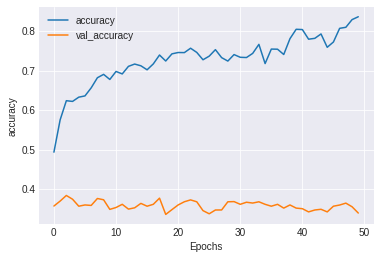

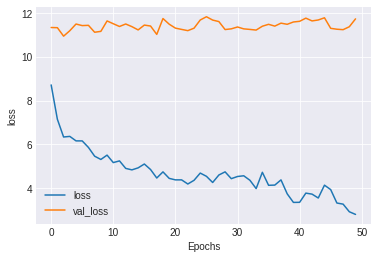

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [0]:
predictions = probability_model.predict(x_val)

In [0]:
predict_valid = np.argmax(predictions, axis = 1).astype(int)
# predict_valid = np.zeros(predictions.shape)
# predict_valid[x == 0,0] = 1
# predict_valid[x == 1,1] = 1
# predict_valid[x == 2,2] = 1
# predict_valid = predict_valid.astype(int)
# predict_valid.shape
predict_valid =  list(predict_valid)

In [0]:
def decode(datum):
    return np.argmax(datum)
def transform_y(y_val):
  y_true = []
  for i in range(y_val.shape[0]):
      y_true.append(decode(y_val[i]))
  y_true = np.array(y_true).astype(int)
  y_true = y_true.tolist()
  return y_true

In [0]:
y_true = transform_y(y_val)
y_true[:5]

[1, 1, 0, 0, 0]

In [0]:
predict_valid[:5]

[0, 0, 0, 0, 0]

In [0]:
# pred_table = pd.merge(predict_valid,y_true)
pred_table = pd.DataFrame({'Pred':predict_valid, 'y_truth':y_true},columns=['Pred','y_truth'])
pred_table.dropna(inplace=True)
pred_table.head()

,Pred,y_truth
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0


In [0]:
df_eval = df[['time','close','12EMA','50EMA','100EMA','15SMA','SMA_ret_holding1']].copy()
# df_eval['time'] = pd.to_datetime(df_eval['time'])
# df_eval = df_eval[df_eval['time'] > "2015-01-01"]
# df_eval.set_index('time',inplace=True)
# df_eval = df_eval.loc['1/1/2017':]
df_eval = df_eval.loc[TRAIN_SPLIT:]
df_eval = df_eval.reset_index(drop=True)
df_eval.head()

,time,close,12EMA,50EMA,100EMA,15SMA,SMA_ret_holding1
0,2018-06-20,6761.27,6785.233490,7564.762277,8147.931823,6324.187333,-0.064645
1,2018-06-21,6720.64,6775.296030,7531.659442,8119.668619,6309.090000,-0.061237
2,2018-06-22,6051.47,6663.938179,7473.612798,8078.714190,6301.182000,0.041265
3,2018-06-23,6166.54,6587.415382,7422.355041,8040.849355,6348.289333,0.029473
4,2018-06-24,6157.78,6521.317631,7372.763863,8003.560853,6384.345333,0.036793


In [0]:
df_eval = pd.merge(df_eval, pred_table, left_index=True, right_index=True)
# df_eval.dropna(inplace=True)
df_eval.head()

,time,close,12EMA,50EMA,100EMA,15SMA,SMA_ret_holding1,Pred,y_truth
0,2018-06-20,6761.27,6785.233490,7564.762277,8147.931823,6324.187333,-0.064645,0,1
1,2018-06-21,6720.64,6775.296030,7531.659442,8119.668619,6309.090000,-0.061237,0,1
2,2018-06-22,6051.47,6663.938179,7473.612798,8078.714190,6301.182000,0.041265,0,0
3,2018-06-23,6166.54,6587.415382,7422.355041,8040.849355,6348.289333,0.029473,0,0
4,2018-06-24,6157.78,6521.317631,7372.763863,8003.560853,6384.345333,0.036793,0,0


In [0]:
# df_eval['position'] = np.where(df_eval['Pred']==0,1,np.where(df_eval['Pred'] == 1,-1,np.nan))
# df_eval['position'] = df_eval['position'].fillna(method='ffill')
# df_eval['position'] = df_eval['position'].fillna(0)
# df_eval['daily_ret'] = df_eval['close'] / df_eval['close'].shift(1) -1 
# df_eval['daily_ret'] = df_eval['daily_ret'].fillna(0)
# df_eval['port_ret'] = df_eval['position'] * df_eval['daily_ret']
# df_eval['port_ret'] = df_eval['port_ret'].fillna(0)
# df_eval['cum_ret'] = np.cumprod(1+df_eval['port_ret'])
# df_eval['buy_and_hold'] = np.cumprod(1+df_eval['daily_ret'])

# # Benchmark model
# df_eval['bm_signal'] = np.where((df_eval['12EMA'] > df_eval['50EMA']) & (df_eval['50EMA'] > df_eval['100EMA']), 0, np.where((df_eval['12EMA'] < df_eval['50EMA']) & (df_eval['50EMA'] < df_eval['100EMA']), 1,2))
# df_eval['bm_position'] = np.where(df_eval['bm_signal']==0,1,np.where(df_eval['bm_signal'] == 1,-1,np.nan))
# df_eval['bm_position'] = df_eval['bm_position'].fillna(method='ffill')
# df_eval['bm_position'] = df_eval['bm_position'].fillna(0)
# df_eval['bm_port_ret'] = df_eval['bm_position'] * df_eval['daily_ret']
# df_eval['bm_cum_ret'] = np.cumprod(1+df_eval['bm_port_ret'])

# # Ideal model
# df_eval['ideal_position'] = np.where(df_eval['y_truth']==0,1,np.where(df_eval['y_truth'] == 1,-1,np.nan))
# df_eval['ideal_position'] = df_eval['ideal_position'].fillna(method='ffill')
# df_eval['ideal_position'] = df_eval['ideal_position'].fillna(0)
# df_eval['ideal_port_ret'] = df_eval['ideal_position'] * df_eval['daily_ret']
# df_eval['ideal_cum_ret'] = np.cumprod(1+df_eval['ideal_port_ret'])

# df_eval.set_index('time',inplace=True)
# df_eval.tail()

In [0]:
df_eval.head()

,time,close,12EMA,50EMA,100EMA,15SMA,SMA_ret_holding1,Pred,y_truth
0,2018-06-20,6761.27,6785.233490,7564.762277,8147.931823,6324.187333,-0.064645,0,1
1,2018-06-21,6720.64,6775.296030,7531.659442,8119.668619,6309.090000,-0.061237,0,1
2,2018-06-22,6051.47,6663.938179,7473.612798,8078.714190,6301.182000,0.041265,0,0
3,2018-06-23,6166.54,6587.415382,7422.355041,8040.849355,6348.289333,0.029473,0,0
4,2018-06-24,6157.78,6521.317631,7372.763863,8003.560853,6384.345333,0.036793,0,0


In [0]:
df_eval['position'] = np.where(df_eval['Pred']==0,1,np.where(df_eval['Pred'] == 1,-1,np.nan))
df_eval['position'] = df_eval['position'].fillna(method='ffill')
df_eval['position'] = df_eval['position'].fillna(0)
df_eval['daily_ret'] = (df_eval['close'] - df_eval['close'].shift(1)).shift(-1)
df_eval['daily_ret'] = df_eval['daily_ret'].fillna(0)
df_eval['port_ret'] = df_eval['position'] * df_eval['daily_ret']
df_eval['port_ret'] = df_eval['port_ret'].fillna(0)
df_eval['cum_ret'] = np.cumsum(df_eval['port_ret'])
df_eval['buy_and_hold'] = np.cumsum(df_eval['daily_ret'])

# Benchmark model
df_eval['bm_signal'] = np.where((df_eval['12EMA'] > df_eval['50EMA']) & (df_eval['50EMA'] > df_eval['100EMA']), 0, np.where((df_eval['12EMA'] < df_eval['50EMA']) & (df_eval['50EMA'] < df_eval['100EMA']), 1,2))
df_eval['bm_position'] = np.where(df_eval['bm_signal']==0,1,np.where(df_eval['bm_signal'] == 1,-1,np.nan))
df_eval['bm_position'] = df_eval['bm_position'].fillna(method='ffill')
df_eval['bm_position'] = df_eval['bm_position'].fillna(0)
df_eval['bm_port_ret'] = df_eval['bm_position'] * df_eval['daily_ret']
df_eval['bm_cum_ret'] = np.cumsum(df_eval['bm_port_ret'])

# Ideal model
df_eval['ideal_position'] = np.where(df_eval['y_truth']==0,1,np.where(df_eval['y_truth'] == 1,-1,np.nan))
df_eval['ideal_position'] = df_eval['ideal_position'].fillna(method='ffill')
df_eval['ideal_position'] = df_eval['ideal_position'].fillna(0)
df_eval['ideal_port_ret'] = df_eval['ideal_position'] * df_eval['daily_ret']
df_eval['ideal_cum_ret'] = np.cumsum(df_eval['ideal_port_ret'])

df_eval.set_index('time',inplace=True)
df_eval.tail()

,close,12EMA,50EMA,100EMA,15SMA,SMA_ret_holding1,Pred,y_truth,position,daily_ret,port_ret,cum_ret,buy_and_hold,bm_signal,bm_position,bm_port_ret,bm_cum_ret,ideal_position,ideal_port_ret,ideal_cum_ret
time,,,,,,,,,,,,,,,,,,,,
2020-03-09,7944.40,8725.465245,9011.121654,8813.570971,6105.781333,-0.231436,1,1,-1.0,-49.74,49.74,6095.35,1133.39,2,1.0,-49.74,1586.95,-1.0,49.74,57191.61
2020-03-10,7894.66,8597.649054,8967.338844,8795.374714,6027.300000,-0.236535,1,1,-1.0,50.70,-50.70,6044.65,1184.09,2,1.0,50.70,1637.65,-1.0,-50.70,57140.91
2020-03-11,7945.36,8497.296892,8927.261242,8778.542739,5947.270000,-0.251479,1,1,-1.0,-3028.58,3028.58,9073.23,-1844.49,2,1.0,-3028.58,-1390.93,-1.0,3028.58,60169.49
2020-03-12,4916.78,7946.448139,8769.987468,8702.072190,5868.109333,0.193486,1,0,-1.0,715.80,-715.80,8357.43,-1128.69,2,1.0,715.80,-675.13,1.0,715.80,60885.29
2020-03-13,5632.58,7590.468425,8646.951881,8641.290167,5987.708000,0.063049,1,0,-1.0,0.00,-0.00,8357.43,-1128.69,2,1.0,0.00,-675.13,1.0,0.00,60885.29


In [0]:
df_eval.head()

,close,12EMA,50EMA,100EMA,15SMA,SMA_ret_holding1,Pred,y_truth,position,daily_ret,port_ret,cum_ret,buy_and_hold,bm_signal,bm_position,bm_port_ret,bm_cum_ret,ideal_position,ideal_port_ret,ideal_cum_ret
time,,,,,,,,,,,,,,,,,,,,
2018-06-20,6761.27,6785.233490,7564.762277,8147.931823,6324.187333,-0.064645,0,1,1.0,-40.63,-40.63,-40.63,-40.63,1,-1.0,40.63,40.63,-1.0,40.63,40.63
2018-06-21,6720.64,6775.296030,7531.659442,8119.668619,6309.090000,-0.061237,0,1,1.0,-669.17,-669.17,-709.80,-709.80,1,-1.0,669.17,709.80,-1.0,669.17,709.80
2018-06-22,6051.47,6663.938179,7473.612798,8078.714190,6301.182000,0.041265,0,0,1.0,115.07,115.07,-594.73,-594.73,1,-1.0,-115.07,594.73,1.0,115.07,824.87
2018-06-23,6166.54,6587.415382,7422.355041,8040.849355,6348.289333,0.029473,0,0,1.0,-8.76,-8.76,-603.49,-603.49,1,-1.0,8.76,603.49,1.0,-8.76,816.11
2018-06-24,6157.78,6521.317631,7372.763863,8003.560853,6384.345333,0.036793,0,0,1.0,102.57,102.57,-500.92,-500.92,1,-1.0,-102.57,500.92,1.0,102.57,918.68


In [0]:
df_eval.loc[df_eval['ideal_port_ret']>0]['ideal_port_ret'].mean()

219.32197007481292

In [0]:
df_eval.loc[df_eval['ideal_port_ret']<0]['ideal_port_ret'].mean()

-117.15506493506498

In [0]:
df_eval.loc[df_eval['ideal_port_ret']>0]['ideal_port_ret'].count() / df_eval['ideal_port_ret'].count() *100

63.34913112164296

In [0]:
df_eval.loc[df_eval['bm_port_ret']>0]['bm_port_ret'].mean()

176.4441358024691

In [0]:
df_eval.loc[df_eval['bm_port_ret']<0]['bm_port_ret'].mean()

-187.80204545454558

In [0]:
df_eval.loc[df_eval['bm_port_ret']>0]['bm_port_ret'].count() / df_eval['bm_port_ret'].count() *100

51.18483412322274

In [0]:
df_eval.loc[df_eval['port_ret']>0]['port_ret'].mean()

185.79572289156638

In [0]:
df_eval.loc[df_eval['port_ret']<0]['port_ret'].mean()

-177.7558333333333

In [0]:
df_eval.loc[df_eval['port_ret']>0]['port_ret'].count() / df_eval['port_ret'].count() *100

52.44865718799369

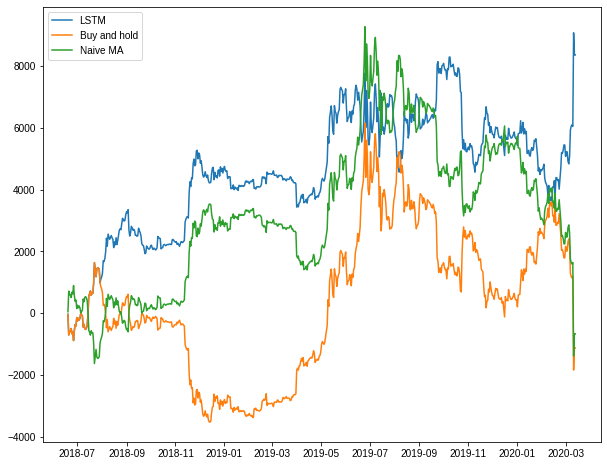

In [0]:
plt.figure(figsize=(10, 8))
plt.plot(df_eval.index, df_eval['cum_ret'], label = 'LSTM')
plt.plot(df_eval.index, df_eval['buy_and_hold'], label = "Buy and hold")
plt.plot(df_eval.index, df_eval['bm_cum_ret'], label = "Naive MA")
# plt.plot(df_eval.index, df_eval['ideal_cum_ret'], label = "Ideal")
plt.legend()
plt.style.use('seaborn-darkgrid')

In [0]:
# Accuracy matrix
label_dict = {0:"Buy", 1:"Sell", 2:"Hold"}
y_true_label = [label_dict[x] for x in y_true]
predict_valid_label = [label_dict[x] for x in predict_valid]
acc_mtx_labels = np.unique(y_true_label)
accuracy_matrix = confusion_matrix(y_true_label, predict_valid_label, labels = acc_mtx_labels)
pd.DataFrame(accuracy_matrix, index=acc_mtx_labels, columns=acc_mtx_labels)

,Buy,Hold,Sell
Buy,132,0,117
Hold,84,0,96
Sell,69,0,135


In [0]:
# Accuracy for all signals
accuracy_matrix_percentage = accuracy_matrix / accuracy_matrix.astype(np.float).sum()
print('Total accuracy:', np.trace(accuracy_matrix_percentage)*100)

Total accuracy: 42.18009478672986


Text(0.5, 18.5, 'Model Prediction')

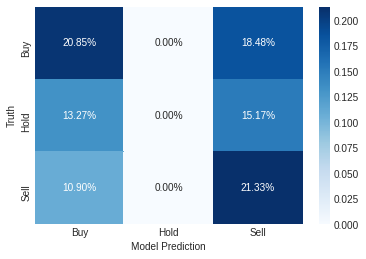

In [0]:
# Confusion Matrix Heatmap
acc_df = pd.DataFrame(accuracy_matrix_percentage, index=acc_mtx_labels, columns=acc_mtx_labels)
ax = sns.heatmap(acc_df,  
            fmt='.2%', cmap='Blues',annot=True)
# X - Y axis labels
ax.set_ylabel('Truth')
ax.set_xlabel('Model Prediction')

## CNN

In [0]:
ticker = 'BTC'
data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
df = pd.read_csv(data_dir)
df.head()
# ticker = 'SPX'
# data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
# df = pd.read_csv(data_dir)
# df.head()

,time,close,high,low,open,volumefrom,volumeto,ret_holding,15SMA,SMA_ret_holding1,buy_signal,sell_signal,hold_signal,close_ret,12EMA,50EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI
0,2013-04-11,124.90,188.7,110.20,165.0,118747.72,18867223.23,-0.063251,133.710000,0.015367,1,0,0,-0.243030,145.284333,87.712684,60.798513,19.204489,28.229613,2.618666,52.534220,12.516431,30.091575,213.472003,60.737997,30.593601,1.095791e+08,62.609170
1,2013-04-12,117.00,140.0,54.25,124.9,556468.03,47619189.45,-0.205128,135.764667,0.001228,0,0,1,-0.063251,140.932898,88.861206,61.911414,27.806557,22.955601,-1.440933,50.594625,-29.038179,-2.600867,211.884738,66.110976,34.533343,1.316533e+08,52.254324
2,2013-04-13,93.00,130.0,85.50,117.0,238347.58,26277415.26,-0.032258,135.931333,-0.001074,0,0,1,-0.205128,133.558606,89.023512,62.527030,25.146848,20.759888,-5.680621,45.141858,-6.093979,-7.538576,211.795017,66.316412,35.245247,1.142335e+08,47.746081
3,2013-04-14,90.00,110.0,84.44,93.0,166274.96,16197017.56,-0.084556,135.785333,-0.005224,0,1,0,-0.032258,126.857282,89.061805,63.071049,23.959408,19.586011,-8.457816,44.496306,-17.387097,-17.506418,212.140937,65.537634,34.553444,1.050830e+08,45.445031
4,2013-04-15,82.39,102.0,71.51,90.0,236673.01,20607774.11,-0.170288,135.076000,-0.017590,0,1,0,-0.084556,120.016161,88.800166,63.453602,25.223837,18.243578,-10.447686,42.823364,-23.820312,-15.767130,214.284307,60.307122,34.263198,9.918256e+07,41.923978


In [0]:
print('number of buy signals',df['buy_signal'].sum())
print('number of sell signals',df['sell_signal'].sum())
print('number of hold signals',df['hold_signal'].sum())

number of buy signals 826
number of sell signals 641
number of hold signals 1075


In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = int(df.shape[0]*0.75)
# TRAIN_SPLIT = 1500
TRAIN_SPLIT

1906

In [0]:
df.columns

Index(['time', 'close', 'high', 'low', 'open', 'volumefrom', 'volumeto',
       'ret_holding', '15SMA', 'SMA_ret_holding1', 'buy_signal', 'sell_signal',
       'hold_signal', 'close_ret', '12EMA', '50EMA', '100EMA', 'minusDI',
       'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal', 'BB_hband',
       'BB_lband', 'ATR', 'ADI', 'MFI'],
      dtype='object')

In [0]:
df.shape

(2542, 28)

In [0]:
df['12_100EMA'] = df['12EMA'] / df['100EMA'] 
df['50_100EMA'] = df['50EMA'] / df['100EMA'] 
# df.dropna(inplace=True)

# features_considered  = ['close', 'high', 'low', 'open', 'volumefrom', 'volumeto',
#        '12EMA', '50EMA', '100EMA', 'minusDI',
#        'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
#        'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']
# features_considered  = ['12_100EMA','50_100EMA',
#                         'MACD','minusDI','plusDI']
features_considered  = ['close', 'high', 'low', 'open', 'volumeto',
       '12_100EMA','50_100EMA', '100EMA', 'minusDI',
       'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
       'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']

y_labels = ['buy_signal', 'sell_signal', 'hold_signal']
signals = ['buy', 'sell', 'hold']

In [0]:
features = df[features_considered]
df['time'] = pd.to_datetime(df['time'])
features.index = df['time']
features.head()

,close,high,low,open,volumeto,12_100EMA,50_100EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI
time,,,,,,,,,,,,,,,,,,,
2013-04-11,124.90,188.7,110.20,165.0,18867223.23,2.389603,1.442678,60.798513,19.204489,28.229613,2.618666,52.534220,12.516431,30.091575,213.472003,60.737997,30.593601,1.095791e+08,62.609170
2013-04-12,117.00,140.0,54.25,124.9,47619189.45,2.276364,1.435296,61.911414,27.806557,22.955601,-1.440933,50.594625,-29.038179,-2.600867,211.884738,66.110976,34.533343,1.316533e+08,52.254324
2013-04-13,93.00,130.0,85.50,117.0,26277415.26,2.136014,1.423760,62.527030,25.146848,20.759888,-5.680621,45.141858,-6.093979,-7.538576,211.795017,66.316412,35.245247,1.142335e+08,47.746081
2013-04-14,90.00,110.0,84.44,93.0,16197017.56,2.011339,1.412087,63.071049,23.959408,19.586011,-8.457816,44.496306,-17.387097,-17.506418,212.140937,65.537634,34.553444,1.050830e+08,45.445031
2013-04-15,82.39,102.0,71.51,90.0,20607774.11,1.891400,1.399450,63.453602,25.223837,18.243578,-10.447686,42.823364,-23.820312,-15.767130,214.284307,60.307122,34.263198,9.918256e+07,41.923978


In [0]:
def preprocess_features(features):
  
  x_dataset = features.values
  train_split = TRAIN_SPLIT

  # standardize the dataset using the mean and standard deviation of the training data.
  data_mean = x_dataset[:train_split].mean(axis=0)
  data_std = x_dataset[:train_split].std(axis=0)
  x_dataset = (x_dataset-data_mean)/data_std

  # standardize the x_dataset using minmax scaler
  # data_max = x_dataset[:train_split].max(axis=0)
  # data_min = x_dataset[:train_split].min(axis=0)
  # x_dataset = (x_dataset-data_min)/(data_max - data_min)

  # Wavelet transform
  # coeffs, freqs = pywt.cwt(x_dataset,scales=np.arange(1,2),wavelet='morl')
  # x_dataset = coeffs.reshape(-1, coeffs.shape[-1])

  return x_dataset

In [0]:
x_dataset = preprocess_features(features)
x_dataset[:2]

array([[-0.5442051 , -0.52361051, -0.55274671, -0.53129484, -0.37409337,
         4.94928789,  3.53931074, -0.56444962, -0.18539161,  0.49457433,
         0.04143985, -0.09305321, -0.07332226,  0.27412154, -0.51024815,
        -0.57483104, -0.36714474, -0.49494998,  0.52104963],
       [-0.54659749, -0.53776083, -0.57067596, -0.54344284, -0.31677797,
         4.51263127,  3.47229894, -0.56407109,  0.75802479, -0.01470902,
        -0.00735964, -0.22891998, -0.83220591, -0.38902028, -0.51065654,
        -0.5728323 , -0.35541011, -0.49329969, -0.07228978]])

In [0]:
def preprocess_outcome(outcome):
  return outcome.values

In [0]:
outcome = df[y_labels]
df['time'] = pd.to_datetime(df['time'])
outcome.index = df['time']

y_dataset = preprocess_outcome(outcome)
y_dataset

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [0]:
y_dataset.shape

(2542, 3)

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size):
  start_index = start_index + history_size
  labels = target[start_index: end_index]
  data = []
  
  
  if end_index is None:
    end_index = len(dataset) 

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

  return np.array(data), labels

In [0]:
past_history = 15

x_train, y_train  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                   start_index = 0, end_index = TRAIN_SPLIT, 
                                   history_size = past_history,
                                   )
x_val, y_val  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                   start_index = TRAIN_SPLIT-past_history, end_index = None, 
                                   history_size = past_history,
                                   )

In [0]:
print('x train shape:',x_train.shape,
      'y train shape:',y_train.shape,
      'x val shape:', x_val.shape,
      'y val shape:', y_val.shape)

x train shape: (1891, 15, 19) y train shape: (1891, 3) x val shape: (636, 15, 19) y val shape: (636, 3)


In [0]:
# Data Augmentation
y_train_df = pd.DataFrame(y_train,columns=['buy','sell','hold'])
print('buy signals',y_train_df['buy'].sum())
print('sell singlas',y_train_df['sell'].sum())
print('hold singals',y_train_df['hold'].sum())

from random import choices
# k = max(int((df['buy_signal'].sum() - df['hold_signal'].sum())/2),0)
# hold_indices = list(y_train_df.loc[y_train_df['hold']==1].index)
# hold_indices = choices(hold_indices,k=k)

k1 = max(int(- df['buy_signal'].sum() + 10000),0)
k2 = max(int(- df['sell_signal'].sum() + 10000),0)
k3 = max(int(- df['hold_signal'].sum() + 10000),0)
buy_indices = list(y_train_df.loc[y_train_df['buy']==1].index)
buy_indices = choices(buy_indices,k=k1)
sell_indices = list(y_train_df.loc[y_train_df['sell']==1].index)
sell_indices = choices(sell_indices,k=k2)
hold_indices = list(y_train_df.loc[y_train_df['hold']==1].index)
hold_indices = choices(hold_indices,k=k3)

buy signals 655
sell singlas 473
hold singals 763


In [0]:
# x_hold_resampled = x_train[hold_indices]
# y_hold_resampled = y_train[hold_indices]
# x_train = np.concatenate((x_train, x_hold_resampled))
# y_train = np.concatenate((y_train, y_hold_resampled))

x_buy_resampled = x_train[buy_indices]
y_buy_resampled = y_train[buy_indices]
x_train = np.concatenate((x_train, x_buy_resampled))
y_train = np.concatenate((y_train, y_buy_resampled))

x_sell_resampled = x_train[sell_indices]
y_sell_resampled = y_train[sell_indices]
x_train = np.concatenate((x_train, x_sell_resampled))
y_train = np.concatenate((y_train, y_sell_resampled))

x_hold_resampled = x_train[hold_indices]
y_hold_resampled = y_train[hold_indices]
x_train = np.concatenate((x_train, x_hold_resampled))
y_train = np.concatenate((y_train, y_hold_resampled))

In [0]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

In [0]:
y_train_df = pd.DataFrame(y_train,columns=['buy','sell','hold'])
print('buy signals',y_train_df['buy'].sum())
print('sell singlas',y_train_df['sell'].sum())
print('hold singals',y_train_df['hold'].sum())

buy signals 9829
sell singlas 9832
hold singals 9688


In [0]:
# Self-defined loss function
"""Since the loss of buy/sell missclassification is higher,
we give more costs on such loss function"""

from keras.utils import np_utils
import keras.backend as K
from itertools import product
import functools

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.expand_dims(y_pred_max, 1)
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):

        final_mask += (K.cast(weights[c_t, c_p],K.floatx()) * K.cast(y_pred_max_mat[:, c_p] ,K.floatx())* K.cast(y_true[:, c_t],K.floatx()))
    return K.categorical_crossentropy(y_pred, y_true) * final_mask
w_array = np.ones((3,3))
w_array[0,1] = 1.2   # buy becomes sell
w_array[1,0] = 1.2   # sell becomes buy
ncce = functools.partial(w_categorical_crossentropy, weights=w_array)
ncce.__name__ ='w_categorical_crossentropy'

In [0]:
""" Construct CNN Classifier Model """
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Softmax
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten 

n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=12, kernel_size=2, activation='relu', padding='same', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=10, kernel_size=2, activation='relu', padding='same', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=6, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=2, strides=2,))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])    

# Show model structure
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 15, 12)            468       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 15, 10)            250       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 15, 6)             126       
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 6)             0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 7, 6)              0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 42)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)             

In [0]:
epochs = 100

history = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=epochs, 
                    batch_size=BATCH_SIZE, verbose=0)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


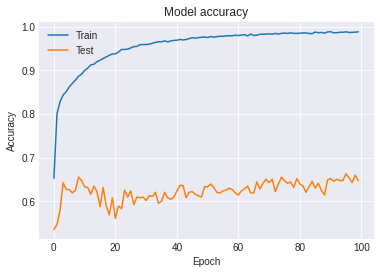

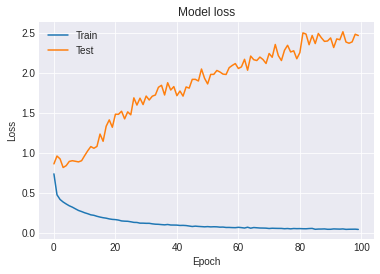

In [0]:
# evaluate model
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# probability_model = tf.keras.Sequential([model, 
#                                          tf.keras.layers.Softmax()])
probability_model = Sequential([model, Softmax()])

In [0]:
predictions = probability_model.predict(x_val)

In [0]:
predict_valid = np.argmax(predictions, axis = 1).astype(int)
# predict_valid = np.zeros(predictions.shape)
# predict_valid[x == 0,0] = 1
# predict_valid[x == 1,1] = 1
# predict_valid[x == 2,2] = 1
# predict_valid = predict_valid.astype(int)
# predict_valid.shape
predict_valid =  list(predict_valid)

In [0]:
def decode(datum):
    return np.argmax(datum)
def transform_y(y_val):
  y_true = []
  for i in range(y_val.shape[0]):
      y_true.append(decode(y_val[i]))
  y_true = np.array(y_true).astype(int)
  y_true = y_true.tolist()
  return y_true

In [0]:
y_true = transform_y(y_val)
y_true[:5]

[2, 2, 2, 2, 2]

In [0]:
predict_valid[:5]

[1, 2, 2, 1, 2]

In [0]:
# pred_table = pd.merge(predict_valid,y_true)
pred_table = pd.DataFrame({'Pred':predict_valid, 'y_truth':y_true},columns=['Pred','y_truth'])
pred_table.dropna(inplace=True)
pred_table.head()

,Pred,y_truth
0,1,2
1,2,2
2,2,2
3,1,2
4,2,2


In [0]:
df_eval = df[['time','close','12EMA','50EMA','100EMA']].copy()
# df_eval['time'] = pd.to_datetime(df_eval['time'])
# df_eval = df_eval[df_eval['time'] > "2015-01-01"]
# df_eval.set_index('time',inplace=True)
# df_eval = df_eval.loc['1/1/2017':]
df_eval = df_eval.loc[TRAIN_SPLIT:]
df_eval = df_eval.reset_index(drop=True)
df_eval.head()

,time,close,12EMA,50EMA,100EMA
0,2018-06-30,6385.38,6300.517040,7114.188175,7795.050665
1,2018-07-01,6339.04,6306.443649,7083.790207,7766.218771
2,2018-07-02,6615.66,6354.015395,7065.432160,7743.435429
3,2018-07-03,6509.58,6377.948411,7043.634036,7719.002648
4,2018-07-04,6590.06,6410.580963,7025.846819,7696.647348


In [0]:
df_eval = pd.merge(df_eval, pred_table, left_index=True, right_index=True)
# df_eval.dropna(inplace=True)
df_eval.head()

,time,close,12EMA,50EMA,100EMA,Pred,y_truth
0,2018-06-30,6385.38,6300.517040,7114.188175,7795.050665,1,2
1,2018-07-01,6339.04,6306.443649,7083.790207,7766.218771,2,2
2,2018-07-02,6615.66,6354.015395,7065.432160,7743.435429,2,2
3,2018-07-03,6509.58,6377.948411,7043.634036,7719.002648,1,2
4,2018-07-04,6590.06,6410.580963,7025.846819,7696.647348,2,2


In [0]:
df_eval['position'] = np.where(df_eval['Pred']==0,1,np.where(df_eval['Pred'] == 1,-1,np.nan))
df_eval['position'] = df_eval['position'].fillna(method='ffill')
df_eval['position'] = df_eval['position'].fillna(0)
df_eval['daily_ret'] = (df_eval['close'] - df_eval['close'].shift(1)).shift(-1)
df_eval['daily_ret'] = df_eval['daily_ret'].fillna(0)
df_eval['port_ret'] = df_eval['position'] * df_eval['daily_ret']
df_eval['port_ret'] = df_eval['port_ret'].fillna(0)
df_eval['cum_ret'] = np.cumsum(df_eval['port_ret'])
df_eval['buy_and_hold'] = np.cumsum(df_eval['daily_ret'])

# Benchmark model
df_eval['bm_signal'] = np.where((df_eval['12EMA'] > df_eval['50EMA']) & (df_eval['50EMA'] > df_eval['100EMA']), 0, np.where((df_eval['12EMA'] < df_eval['50EMA']) & (df_eval['50EMA'] < df_eval['100EMA']), 1,2))
df_eval['bm_position'] = np.where(df_eval['bm_signal']==0,1,np.where(df_eval['bm_signal'] == 1,-1,np.nan))
df_eval['bm_position'] = df_eval['bm_position'].fillna(method='ffill')
df_eval['bm_position'] = df_eval['bm_position'].fillna(0)
df_eval['bm_port_ret'] = df_eval['bm_position'] * df_eval['daily_ret']
df_eval['bm_cum_ret'] = np.cumsum(df_eval['bm_port_ret'])

# Ideal model
df_eval['ideal_position'] = np.where(df_eval['y_truth']==0,1,np.where(df_eval['y_truth'] == 1,-1,np.nan))
df_eval['ideal_position'] = df_eval['ideal_position'].fillna(method='ffill')
df_eval['ideal_position'] = df_eval['ideal_position'].fillna(0)
df_eval['ideal_port_ret'] = df_eval['ideal_position'] * df_eval['daily_ret']
df_eval['ideal_cum_ret'] = np.cumsum(df_eval['ideal_port_ret'])

df_eval.set_index('time',inplace=True)
df_eval.tail()

,close,12EMA,50EMA,100EMA,Pred,y_truth,position,daily_ret,port_ret,cum_ret,buy_and_hold,bm_signal,bm_position,bm_port_ret,bm_cum_ret,ideal_position,ideal_port_ret,ideal_cum_ret
time,,,,,,,,,,,,,,,,,,
2020-03-22,5828.15,6184.406766,7748.461133,8149.698925,1,1,-1.0,675.38,-675.38,10074.49,118.15,1,-1.0,-675.38,-2823.59,-1.0,-675.38,16151.71
2020-03-23,6503.53,6233.502648,7699.640304,8117.101520,1,1,-1.0,263.65,-263.65,9810.84,381.80,1,-1.0,-263.65,-3087.24,-1.0,-263.65,15888.06
2020-03-24,6767.18,6315.606856,7663.073233,8090.370401,2,1,-1.0,-72.97,72.97,9883.81,308.83,1,-1.0,72.97,-3014.27,-1.0,72.97,15961.03
2020-03-25,6694.21,6373.853494,7625.078597,8062.723661,2,1,-1.0,63.74,-63.74,9820.07,372.57,1,-1.0,-63.74,-3078.01,-1.0,-63.74,15897.29
2020-03-26,6757.95,6432.945264,7591.073554,8036.886558,0,0,1.0,0.00,0.00,9820.07,372.57,1,-1.0,-0.00,-3078.01,1.0,0.00,15897.29


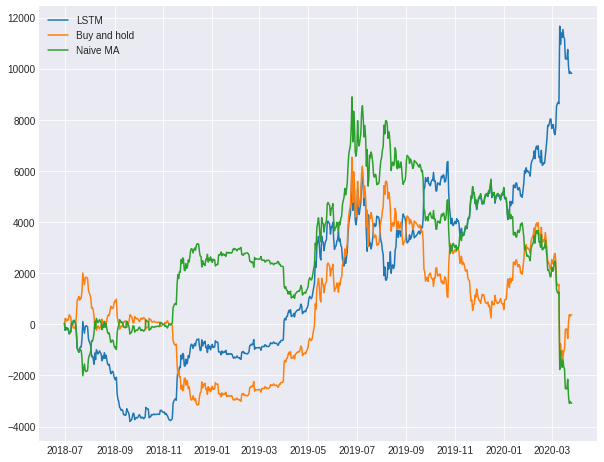

In [0]:
plt.figure(figsize=(10, 8))
plt.plot(df_eval.index, df_eval['cum_ret'], label = 'LSTM')
plt.plot(df_eval.index, df_eval['buy_and_hold'], label = "Buy and hold")
plt.plot(df_eval.index, df_eval['bm_cum_ret'], label = "Naive MA")
# plt.plot(df_eval.index, df_eval['ideal_cum_ret'], label = "Ideal")
plt.legend()
plt.style.use('seaborn-darkgrid')

In [0]:
# Accuracy matrix
label_dict = {0:"Buy", 1:"Sell", 2:"Hold"}
y_true_label = [label_dict[x] for x in y_true]
predict_valid_label = [label_dict[x] for x in predict_valid]
acc_mtx_labels = np.unique(y_true_label)
accuracy_matrix = confusion_matrix(y_true_label, predict_valid_label, labels = acc_mtx_labels)
pd.DataFrame(accuracy_matrix, index=acc_mtx_labels, columns=acc_mtx_labels)

,Buy,Hold,Sell
Buy,124,41,4
Hold,80,170,60
Sell,5,34,118


In [0]:
# Accuracy for all signals
accuracy_matrix_percentage = accuracy_matrix / accuracy_matrix.astype(np.float).sum()
print('Total accuracy:', np.trace(accuracy_matrix_percentage)*100)

Total accuracy: 64.77987421383648


Text(0.5, 18.5, 'Model Prediction')

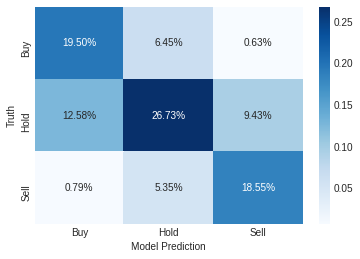

In [0]:
# Confusion Matrix Heatmap
acc_df = pd.DataFrame(accuracy_matrix_percentage, index=acc_mtx_labels, columns=acc_mtx_labels)
ax = sns.heatmap(acc_df,  
            fmt='.2%', cmap='Blues',annot=True)
# X - Y axis labels
ax.set_ylabel('Truth')
ax.set_xlabel('Model Prediction')